In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-11-18 22:21:49.613459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


## MI vs num photons

In [2]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = [20, 40, 80, 160, 300]
num_bootstrap_samples = 80
confidence_interval = 90
patch_size = 20

# patch_size = 5
# num_bootstrap_samples = 3
# num_images = 500
# num_patches = 500
# photons_per_pixel = [20, 200]

if not os.path.exists('.cache'):
    os.mkdir('.cache')

mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
mi_means_by_channel_photons_pixel_cnn = {}
mi_confidences_by_channel_photons_pixel_cnn = {}
mi_means_by_channel_photons_analytic = {}
mi_confidences_by_channel_photons_analytic = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    mi_means_by_channel_photons_pixel_cnn[channel_name] = []
    mi_confidences_by_channel_photons_pixel_cnn[channel_name] = []
    mi_means_by_channel_photons_analytic[channel_name] = []
    mi_confidences_by_channel_photons_analytic[channel_name] = []

    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, 
                               median_filter=True, verbose=False, batch=1)
    for num_photons in photons_per_pixel:
        

      cache_name = '.cache/analytic_entropy_{}_{}_samples.npz'.format(channel_name, num_photons)
      if os.path.exists(cache_name):
        print('loading cached data')
        loaded = onp.load(cache_name)
        # append to the list of estimates
        mi_means_by_channel_photons[channel_name].append(loaded['mi_mean'])
        mi_confidences_by_channel_photons[channel_name].append(loaded['mi_confidence'])
        mi_means_by_channel_photons_pixel_cnn[channel_name].append(loaded['mi_mean_pixel_cnn'])
        mi_confidences_by_channel_photons_pixel_cnn[channel_name].append(loaded['mi_confidence_pixel_cnn'])
        mi_means_by_channel_photons_analytic[channel_name].append(loaded['mi_mean_analytic'])
        mi_confidences_by_channel_photons_analytic[channel_name].append(loaded['mi_confidence_analytic'])
      else:
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
        patches *= num_photons / np.mean(images)
        noisy_patches = add_noise(patches)

        mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False),
                      verbose=True)
        mi_means_by_channel_photons[channel_name].append(mi_mean)
        mi_confidences_by_channel_photons[channel_name].append(mi_confidence)

        mi_mean_pixel_cnn, mi_confidence_pixel_cnn = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, entropy_model='pixel_cnn', verbose=False),
                      verbose=True)
        mi_means_by_channel_photons_pixel_cnn[channel_name].append(mi_mean_pixel_cnn)
        mi_confidences_by_channel_photons_pixel_cnn[channel_name].append(mi_confidence_pixel_cnn)

        mi_mean_analytic, mi_confidence_analytic =  run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False,  analytic_marginal_entropy=True),
                      verbose=True)
        mi_means_by_channel_photons_analytic[channel_name].append(mi_mean_analytic)
        mi_confidences_by_channel_photons_analytic[channel_name].append(mi_confidence_analytic)


        # save all these results to a numpy file
        onp.savez(cache_name[:-4],
          mi_mean=mi_mean,
          mi_confidence=mi_confidence,
          mi_mean_pixel_cnn=mi_mean_pixel_cnn,
          mi_confidence_pixel_cnn=mi_confidence_pixel_cnn,
          mi_mean_analytic=mi_mean_analytic,
          mi_confidence_analytic=mi_confidence_analytic,
                    )

    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}
mi_means_by_channel_photons_pixel_cnn = {channel: np.array(v) for channel, v in mi_means_by_channel_photons_pixel_cnn.items()}
mi_confidences_by_channel_photons_pixel_cnn = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons_pixel_cnn.items()}
mi_means_by_channel_photons_analytic = {channel: np.array(v) for channel, v in mi_means_by_channel_photons_analytic.items()}
mi_confidences_by_channel_photons_analytic = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons_analytic.items()}

 33%|████████████████▎                                | 1/3 [00:13<00:27, 13.77s/it]

loading cached data
loading cached data
loading cached data
loading cached data
loading cached data


 67%|████████████████████████████████▋                | 2/3 [00:24<00:12, 12.01s/it]

loading cached data
loading cached data
loading cached data
loading cached data
loading cached data
loading cached data
loading cached data



Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [3807401032 3973156142] 



2023-11-18 22:23:27.995737: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

Running bootstraps:   1%|▎                           | 1/80 [00:36<48:35, 36.91s/it]

key [1182475919 1048512508] 




Running bootstraps:   2%|▋                           | 2/80 [00:56<34:21, 26.43s/it]

key [3199065872 3505051180] 




Running bootstraps:   4%|█                           | 3/80 [01:11<27:35, 21.50s/it]

key [1629647798 3311293997] 




Running bootstraps:   5%|█▍                          | 4/80 [01:28<25:09, 19.86s/it]

key [618700139 953672082] 




Running bootstraps:   6%|█▊                          | 5/80 [01:45<23:15, 18.60s/it]

key [ 161672328 2503612501] 




Running bootstraps:   8%|██                          | 6/80 [02:01<21:48, 17.68s/it]

key [1912403477 1712610846] 




Running bootstraps:   9%|██▍                         | 7/80 [02:19<21:45, 17.89s/it]

key [3366221343  385787005] 




Running bootstraps:  10%|██▊                         | 8/80 [02:35<20:51, 17.38s/it]

key [893675578 659462875] 




Running bootstraps:  11%|███▏                        | 9/80 [02:51<19:56, 16.86s/it]

key [3373315714 2445911349] 




Running bootstraps:  12%|███▍                       | 10/80 [03:09<19:58, 17.12s/it]

key [2201102151 3753471613] 




Running bootstraps:  14%|███▋                       | 11/80 [03:25<19:17, 16.77s/it]

key [2191569846 1703742082] 




Running bootstraps:  15%|████                       | 12/80 [03:41<18:39, 16.47s/it]

key [ 395693073 1731062641] 




Running bootstraps:  16%|████▍                      | 13/80 [03:59<18:55, 16.95s/it]

key [4222497062 2241825419] 




Running bootstraps:  18%|████▋                      | 14/80 [04:17<19:05, 17.36s/it]

key [3559129105 3690514305] 




Running bootstraps:  19%|█████                      | 15/80 [04:34<18:36, 17.17s/it]

key [1509999571 3728363601] 




Running bootstraps:  20%|█████▍                     | 16/80 [04:50<17:56, 16.82s/it]

key [  3864959 546197066] 




Running bootstraps:  21%|█████▋                     | 17/80 [05:08<18:03, 17.19s/it]

key [4140888253  748994212] 




Running bootstraps:  22%|██████                     | 18/80 [05:28<18:41, 18.10s/it]

key [ 100048929 1248234730] 




Running bootstraps:  24%|██████▍                    | 19/80 [05:49<19:27, 19.14s/it]

key [3989114581 3617739090] 




Running bootstraps:  25%|██████▊                    | 20/80 [06:06<18:13, 18.22s/it]

key [1243953666 3818882150] 




Running bootstraps:  26%|███████                    | 21/80 [06:22<17:20, 17.64s/it]

key [4154450123 1761783266] 




Running bootstraps:  28%|███████▍                   | 22/80 [06:38<16:39, 17.23s/it]

key [4036270917 1225027484] 




Running bootstraps:  29%|███████▊                   | 23/80 [06:57<16:48, 17.69s/it]

key [1635191560  836492502] 




Running bootstraps:  30%|████████                   | 24/80 [07:13<16:11, 17.35s/it]

key [343271035 675497717] 




Running bootstraps:  31%|████████▍                  | 25/80 [07:32<16:16, 17.75s/it]

key [   1479093 3443703666] 




Running bootstraps:  32%|████████▊                  | 26/80 [07:48<15:32, 17.27s/it]

key [1469043775 2373976188] 




Running bootstraps:  34%|█████████                  | 27/80 [08:04<14:57, 16.93s/it]

key [2925212050 1150991255] 




Running bootstraps:  35%|█████████▍                 | 28/80 [08:23<15:08, 17.48s/it]

key [ 826548043 2532791369] 




Running bootstraps:  36%|█████████▊                 | 29/80 [08:40<14:40, 17.26s/it]

key [2781451740 1970957597] 




Running bootstraps:  38%|██████████▏                | 30/80 [08:58<14:41, 17.63s/it]

key [3076442530 4247862250] 




Running bootstraps:  39%|██████████▍                | 31/80 [09:17<14:35, 17.86s/it]

key [1184857884  833101491] 




Running bootstraps:  40%|██████████▊                | 32/80 [09:33<13:50, 17.29s/it]

key [1155135099 4259884205] 




Running bootstraps:  41%|███████████▏               | 33/80 [09:49<13:12, 16.86s/it]

key [3927633684  467042491] 




Running bootstraps:  42%|███████████▍               | 34/80 [10:05<12:47, 16.69s/it]

key [2520070710 3261836561] 




Running bootstraps:  44%|███████████▊               | 35/80 [10:22<12:39, 16.87s/it]

key [3288508353 1780488035] 




Running bootstraps:  45%|████████████▏              | 36/80 [10:40<12:38, 17.24s/it]

key [3308583507 1456693163] 




Running bootstraps:  46%|████████████▍              | 37/80 [10:57<12:17, 17.15s/it]

key [4055984722 3163407081] 




Running bootstraps:  48%|████████████▊              | 38/80 [11:14<11:54, 17.01s/it]

key [4061255884 1052541240] 




Running bootstraps:  49%|█████████████▏             | 39/80 [11:30<11:27, 16.78s/it]

key [3752875610 1590276344] 




Running bootstraps:  50%|█████████████▌             | 40/80 [11:53<12:27, 18.70s/it]

key [1287761056 1777884399] 




Running bootstraps:  51%|█████████████▊             | 41/80 [12:12<12:04, 18.59s/it]

key [1060941567 4221854552] 




Running bootstraps:  52%|██████████████▏            | 42/80 [12:27<11:13, 17.73s/it]

key [3201075405 3877969341] 




Running bootstraps:  54%|██████████████▌            | 43/80 [12:44<10:45, 17.45s/it]

key [3313039134 1585532577] 




Running bootstraps:  55%|██████████████▊            | 44/80 [13:05<11:03, 18.44s/it]

key [4080549759 4177232793] 




Running bootstraps:  56%|███████████████▏           | 45/80 [13:23<10:42, 18.35s/it]

key [ 91560426 124195017] 




Running bootstraps:  57%|███████████████▌           | 46/80 [13:39<09:57, 17.57s/it]

key [2611341219 2358115644] 




Running bootstraps:  59%|███████████████▊           | 47/80 [13:58<09:51, 17.91s/it]

key [3235157356 1502839514] 




Running bootstraps:  60%|████████████████▏          | 48/80 [14:18<09:54, 18.58s/it]

key [2072918210 2171912926] 




Running bootstraps:  61%|████████████████▌          | 49/80 [14:36<09:35, 18.55s/it]

key [3349218460 2702612476] 




Running bootstraps:  62%|████████████████▉          | 50/80 [14:53<08:59, 17.98s/it]

key [3642541289  958165710] 




Running bootstraps:  64%|█████████████████▏         | 51/80 [15:10<08:34, 17.76s/it]

key [2716857276 1032231782] 




Running bootstraps:  65%|█████████████████▌         | 52/80 [15:26<08:00, 17.18s/it]

key [3351247243 3970682286] 




Running bootstraps:  66%|█████████████████▉         | 53/80 [15:41<07:29, 16.67s/it]

key [1137537891 2651497497] 




Running bootstraps:  68%|██████████████████▏        | 54/80 [16:01<07:35, 17.50s/it]

key [1854456468 4187566022] 




Running bootstraps:  69%|██████████████████▌        | 55/80 [16:16<07:02, 16.91s/it]

key [2879595454  284570417] 




Running bootstraps:  70%|██████████████████▉        | 56/80 [16:32<06:37, 16.55s/it]

key [3584362251 2381489387] 




Running bootstraps:  71%|███████████████████▏       | 57/80 [16:50<06:27, 16.85s/it]

key [2500880272 3984638501] 




Running bootstraps:  72%|███████████████████▌       | 58/80 [17:06<06:10, 16.85s/it]

key [3527053955 3916739428] 




Running bootstraps:  74%|███████████████████▉       | 59/80 [17:22<05:43, 16.38s/it]

key [3666632285 2879535760] 




Running bootstraps:  75%|████████████████████▎      | 60/80 [17:42<05:49, 17.47s/it]

key [2375841875  800340849] 




Running bootstraps:  76%|████████████████████▌      | 61/80 [18:01<05:43, 18.10s/it]

key [2652811614  916443226] 




Running bootstraps:  78%|████████████████████▉      | 62/80 [18:17<05:13, 17.40s/it]

key [  43211071 2814534890] 




Running bootstraps:  79%|█████████████████████▎     | 63/80 [18:33<04:46, 16.83s/it]

key [2199602160 2128153737] 




Running bootstraps:  80%|█████████████████████▌     | 64/80 [18:49<04:26, 16.64s/it]

key [2733843135  195339463] 




Running bootstraps:  81%|█████████████████████▉     | 65/80 [19:09<04:26, 17.79s/it]

key [3722350442 3328054371] 




Running bootstraps:  82%|██████████████████████▎    | 66/80 [19:27<04:10, 17.91s/it]

key [266071178 939296721] 




Running bootstraps:  84%|██████████████████████▌    | 67/80 [19:44<03:47, 17.47s/it]

key [2529013501 1353519173] 




Running bootstraps:  85%|██████████████████████▉    | 68/80 [20:05<03:41, 18.43s/it]

key [ 195363468 2013158932] 




Running bootstraps:  86%|███████████████████████▎   | 69/80 [20:21<03:16, 17.86s/it]

key [466179126 912792588] 




Running bootstraps:  88%|███████████████████████▋   | 70/80 [20:41<03:04, 18.45s/it]

key [2397347955 3235060340] 




Running bootstraps:  89%|███████████████████████▉   | 71/80 [21:00<02:47, 18.56s/it]

key [3363774657 2720326441] 




Running bootstraps:  90%|████████████████████████▎  | 72/80 [21:17<02:26, 18.26s/it]

key [ 148405161 1490541316] 




Running bootstraps:  91%|████████████████████████▋  | 73/80 [21:36<02:08, 18.38s/it]

key [2626614417 4139266506] 




Running bootstraps:  92%|████████████████████████▉  | 74/80 [21:52<01:46, 17.74s/it]

key [3375921638 3399354435] 




Running bootstraps:  94%|█████████████████████████▎ | 75/80 [22:08<01:26, 17.30s/it]

key [2749389760 1809208054] 




Running bootstraps:  95%|█████████████████████████▋ | 76/80 [22:24<01:07, 16.80s/it]

key [ 850562977 2121210468] 




Running bootstraps:  96%|█████████████████████████▉ | 77/80 [22:41<00:50, 16.80s/it]

key [4292599533 1610832450] 




Running bootstraps:  98%|██████████████████████████▎| 78/80 [23:00<00:34, 17.45s/it]

key [313417240 980878628] 




Running bootstraps:  99%|██████████████████████████▋| 79/80 [23:16<00:17, 17.15s/it]

key [1053318822 1146118108] 




Running bootstraps: 100%|███████████████████████████| 80/80 [23:34<00:00, 17.68s/it]

Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [805290053 112821343] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]2023-11-18 22:47:57.806545: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-11-18 22:47:57.806595: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}


Computing loss:   3%|█                               | 1/32 [00:02<01:13,  2.36s/it]

Computing loss:  19%|██████                          | 6/32 [00:02<00:08,  3.22it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:02<00:03,  6.61it/s]

Computing loss:  50%|███████████████▌      

key [2890135692 2255970513] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  19%|██████                          | 6/32 [00:01<00:03,  7.01it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.03it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.68it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.95it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:01,  6.71it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.26it/s]

Running bootstraps:   2%|▋                         | 2/80 [02:25<1:34:41, 72.84s/it]

key [3203687739 2619319986] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.08it/s]

Computing loss:  19%|██████                          | 6/32 [00:01<00:03,  7.38it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.56it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 19.21it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 23.25it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.71it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.79it/s]

Running bootstraps:   4%|▉                         | 3/80 [03:18<1:22:01, 63.92s/it]

key [2683421548 2333134763] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.00it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.88it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.05it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.07it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.87it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.43it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.46it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.02it/s]

Running bootstraps:   5%|█▎                        | 4/80 [04:08<1:14:06, 58.50s/it]

key [2145950541  123599782] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.06it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.08it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.15it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.12it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.65it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.75it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 12.64it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.38it/s]

Running bootstraps:   6%|█▋                        | 5/80 [05:40<1:27:58, 70.38s/it]

key [3973077435 2727005398] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.10it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.39it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.85it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 17.05it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 21.89it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.95it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 12.82it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.76it/s]

Running bootstraps:   8%|█▉                        | 6/80 [06:39<1:22:03, 66.53s/it]

key [ 765403523 1100677559] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.98it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 12.21it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 16.98it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 21.51it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  8.92it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 12.71it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.29it/s]

Running bootstraps:   9%|██▎                       | 7/80 [07:42<1:19:27, 65.31s/it]

key [3528000605 2151680528] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.70it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.66it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 16.78it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 21.06it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  8.79it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 12.53it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.95it/s]

Running bootstraps:  10%|██▌                       | 8/80 [08:45<1:17:30, 64.59s/it]

key [ 353494462 2559344976] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.85it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 12.08it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 16.72it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 21.26it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  8.90it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 12.64it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.15it/s]

Running bootstraps:  11%|██▉                       | 9/80 [09:57<1:19:14, 66.97s/it]

key [2471064404 3820827831] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.67it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.54it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.33it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.83it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.67it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 12.50it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.99it/s]

Running bootstraps:  12%|███▏                     | 10/80 [10:58<1:16:10, 65.29s/it]

key [1869974532 2968786771] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.92it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.12it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.21it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.99it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.74it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.80it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.19it/s]

Running bootstraps:  14%|███▍                     | 11/80 [12:06<1:15:56, 66.04s/it]

key [3298374996 2691222971] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:45,  1.48s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:06,  4.12it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  8.08it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 12.37it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 16.71it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.12it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 11.81it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.25it/s]

Running bootstraps:  15%|███▊                     | 12/80 [13:32<1:21:38, 72.03s/it]

key [ 156914180 4286020295] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.69it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.57it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.27it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.75it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.51it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.46it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.80it/s]

Running bootstraps:  16%|████                     | 13/80 [14:58<1:25:02, 76.16s/it]

key [1653853315 3548440427] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.69it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.70it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.55it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.92it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.70it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 12.52it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.01it/s]

Running bootstraps:  18%|████▍                    | 14/80 [16:08<1:21:48, 74.37s/it]

key [3390879147 3596207967] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.81it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.80it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.51it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.97it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.94it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.79it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.46it/s]

Running bootstraps:  19%|████▋                    | 15/80 [17:16<1:18:33, 72.51s/it]

key [1531223283 3388498346] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.70it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.62it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.44it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.88it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.76it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 11.32it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.36it/s]

Running bootstraps:  20%|█████                    | 16/80 [18:36<1:19:39, 74.69s/it]

key [2892600891  998345658] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.86it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.88it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.78it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.20it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.69it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 12.54it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.14it/s]

Running bootstraps:  21%|█████▎                   | 17/80 [19:47<1:17:20, 73.67s/it]

key [3542540853  862583692] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.10it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.29it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.53it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.44it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.88it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.78it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.80it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.40it/s]

Running bootstraps:  22%|█████▋                   | 18/80 [20:54<1:13:55, 71.54s/it]

key [ 814604535 1334561658] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.70it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.64it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.49it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.87it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.53it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 12.36it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.94it/s]

Running bootstraps:  24%|█████▉                   | 19/80 [22:00<1:11:11, 70.03s/it]

key [3104178268 1387081541] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:50,  1.62s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:07,  3.77it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:03,  7.43it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 11.49it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:02<00:00, 15.65it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:03<00:01,  7.90it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:03<00:00, 11.48it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00,  9.72it/s]

Running bootstraps:  25%|██████▎                  | 20/80 [23:16<1:11:55, 71.92s/it]

key [ 593006095 3635061831] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.82it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.78it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.49it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.59it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.23it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.16it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.68it/s]

Running bootstraps:  26%|██████▌                  | 21/80 [24:17<1:07:18, 68.46s/it]

key [2822474400 3288108279] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.63it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.50it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.26it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.51it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.27it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.20it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.56it/s]

Running bootstraps:  28%|██████▉                  | 22/80 [25:21<1:04:56, 67.19s/it]

key [ 651888424 1597079913] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.57it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.43it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.13it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.60it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.66it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.64it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.78it/s]

Running bootstraps:  29%|███████▏                 | 23/80 [26:32<1:04:57, 68.38s/it]

key [1315457272 1802820267] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.14it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.32it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.12it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.51it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.70it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.27it/s]

Running bootstraps:  30%|███████▌                 | 24/80 [27:44<1:04:39, 69.27s/it]

key [1590483061    2604831] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:27,  1.14it/s]

Computing loss:  16%|█████                           | 5/32 [00:00<00:04,  6.46it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.74it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.67it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 21.01it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.60it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.33it/s]

Running bootstraps:  31%|███████▊                 | 25/80 [28:47<1:02:00, 67.64s/it]

key [ 413157523 1943717355] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.77it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.72it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.51it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.76it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.30it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.26it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.72it/s]

Running bootstraps:  32%|████████▏                | 26/80 [29:57<1:01:20, 68.15s/it]

key [2971361105 3871556776] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.65it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.54it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.30it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.56it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.79it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.26it/s]

Running bootstraps:  34%|████████▍                | 27/80 [31:10<1:01:38, 69.79s/it]

key [3614290564 1385146558] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.76it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.67it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.44it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.46it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.47it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.79it/s]

Running bootstraps:  35%|████████▊                | 28/80 [32:24<1:01:32, 71.01s/it]

key [3278892814 1219371233] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.71it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.64it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.41it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.74it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.52it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.42it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.80it/s]

Running bootstraps:  36%|█████████                | 29/80 [33:42<1:02:03, 73.02s/it]

key [2941931359  514579834] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.76it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.69it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.41it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.68it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.96it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.83it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.47it/s]

Running bootstraps:  38%|██████████▏                | 30/80 [34:46<58:33, 70.27s/it]

key [2721530441 1230945976] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.56it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.40it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.17it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.46it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.53it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.52it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.71it/s]

Running bootstraps:  39%|██████████▍                | 31/80 [35:55<57:10, 70.01s/it]

key [867527093 638177408] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.92it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.91it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.77it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.20it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.72it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.10it/s]

Running bootstraps:  40%|██████████▊                | 32/80 [36:54<53:14, 66.55s/it]

key [1397320777  989755459] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.70it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.59it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.32it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.65it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.55it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.50it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.81it/s]

Running bootstraps:  41%|███████████▏               | 33/80 [38:01<52:24, 66.90s/it]

key [3008189137   87370926] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.10it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.15it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.83it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.06it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.82it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.63it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.55it/s]

Running bootstraps:  42%|███████████▍               | 34/80 [39:15<52:54, 69.01s/it]

key [1130791211 3076096163] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.71it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.61it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.23it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.48it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.80it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.61it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.29it/s]

Running bootstraps:  44%|███████████▊               | 35/80 [40:35<54:09, 72.22s/it]

key [2958185760  286817045] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.67it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.52it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.23it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.54it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.53it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.52it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.80it/s]

Running bootstraps:  45%|████████████▏              | 36/80 [41:41<51:30, 70.24s/it]

key [3685499402 1249427303] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.11it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.26it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.14it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.60it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.62it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.61it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.14it/s]

Running bootstraps:  46%|████████████▍              | 37/80 [42:48<49:39, 69.30s/it]

key [ 872873719 1605435860] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.12it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.26it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.16it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.55it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.32it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.21it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.95it/s]

Running bootstraps:  48%|████████████▊              | 38/80 [43:49<46:43, 66.74s/it]

key [3007599540 4262116101] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.67it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.57it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.32it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.67it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.44it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.41it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.72it/s]

Running bootstraps:  49%|█████████████▏             | 39/80 [45:00<46:35, 68.17s/it]

key [1770839716 1692972056] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.68it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.59it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.38it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.78it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.47it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.43it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.76it/s]

Running bootstraps:  50%|█████████████▌             | 40/80 [46:19<47:34, 71.36s/it]

key [3330602163  558686581] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.54it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.34it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.07it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.98it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.23it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.14it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.45it/s]

Running bootstraps:  51%|█████████████▊             | 41/80 [47:22<44:50, 68.98s/it]

key [1582730125 3535195612] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:27,  1.13it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.40it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.65it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.63it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.97it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.63it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.63it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.38it/s]

Running bootstraps:  52%|██████████████▏            | 42/80 [48:33<44:04, 69.60s/it]

key [3313687954  376511882] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:27,  1.11it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.28it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.46it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.41it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.70it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.65it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.66it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.31it/s]

Running bootstraps:  54%|██████████████▌            | 43/80 [49:46<43:32, 70.60s/it]

key [ 281332398 3360784465] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.37it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.04it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.64it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.86it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.25it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.17it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.37it/s]

Running bootstraps:  55%|██████████████▊            | 44/80 [50:43<39:55, 66.54s/it]

key [1427271829 4076666860] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.08it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.16it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.30it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.18it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.49it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.59it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.52it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.13it/s]

Running bootstraps:  56%|███████████████▏           | 45/80 [51:52<39:06, 67.05s/it]

key [2879573660 3836954688] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:27,  1.13it/s]

Computing loss:  16%|█████                           | 5/32 [00:00<00:04,  6.42it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.66it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.52it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.82it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.72it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.73it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.38it/s]

Running bootstraps:  57%|███████████████▌           | 46/80 [52:57<37:46, 66.68s/it]

key [3598859701 2546330458] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.03it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.11it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.99it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.33it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.64it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.05it/s]

Running bootstraps:  59%|███████████████▊           | 47/80 [53:48<34:04, 61.94s/it]

key [2186007544  237279187] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.99it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.00it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.81it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.94it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.61it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.03it/s]

Running bootstraps:  60%|████████████████▏          | 48/80 [55:08<35:50, 67.21s/it]

key [2347381566  175858490] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:27,  1.12it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.36it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.59it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.42it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.71it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.60it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.57it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.28it/s]

Running bootstraps:  61%|████████████████▌          | 49/80 [56:15<34:43, 67.22s/it]

key [1674747919 2802073042] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:27,  1.11it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.32it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:01, 11.57it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.50it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.71it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.68it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.45it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.59it/s]

Running bootstraps:  62%|████████████████▉          | 50/80 [57:22<33:35, 67.18s/it]

key [1331171202 1117317088] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.10it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.06it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.83it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.18it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.49it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.05it/s]

Running bootstraps:  64%|█████████████████▏         | 51/80 [58:06<29:03, 60.14s/it]

key [1150298715 3954298440] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.00it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.78it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.71it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.44it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.69it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.48it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.81it/s]

Running bootstraps:  65%|█████████████████▌         | 52/80 [59:05<27:55, 59.82s/it]

key [3922978686 2606902933] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.14it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.29it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.21it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.51it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.52it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.48it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.11it/s]

Running bootstraps:  66%|████████████████▌        | 53/80 [1:00:22<29:14, 64.99s/it]

key [ 456185368 2554448047] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.10it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.27it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.49it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.45it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.89it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:03<00:02,  4.55it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:03<00:01,  6.45it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00,  8.48it/s]

Running bootstraps:  68%|████████████████▉        | 54/80 [1:01:27<28:09, 65.00s/it]

key [4174133314  384878608] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.06it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.03it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.96it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.77it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.11it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.54it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.50it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.03it/s]

Running bootstraps:  69%|█████████████████▏       | 55/80 [1:02:24<26:04, 62.57s/it]

key [1724741429 1489059271] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.59it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.41it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.02it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.40it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.52it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.48it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.70it/s]

Running bootstraps:  70%|█████████████████▌       | 56/80 [1:03:41<26:44, 66.85s/it]

key [1609651642 3476516769] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.50it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.21it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.71it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.79it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.06it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.89it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.28it/s]

Running bootstraps:  71%|█████████████████▊       | 57/80 [1:04:56<26:34, 69.34s/it]

key [2079782282 3938353622] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.61it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.45it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.20it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.39it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.53it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.49it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.73it/s]

Running bootstraps:  72%|██████████████████▏      | 58/80 [1:06:08<25:45, 70.26s/it]

key [2528547057 1440519670] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.52it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.12it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.70it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.93it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.64it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.47it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.06it/s]

Running bootstraps:  74%|██████████████████▍      | 59/80 [1:07:21<24:48, 70.90s/it]

key [2551407237 4092718119] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.51it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.22it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.92it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.16it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.34it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.23it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.50it/s]

Running bootstraps:  75%|██████████████████▊      | 60/80 [1:08:46<25:01, 75.10s/it]

key [1574082954  368226748] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.57it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.37it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.02it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.88it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.89it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.70it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.24it/s]

Running bootstraps:  76%|███████████████████      | 61/80 [1:09:56<23:19, 73.67s/it]

key [ 187988262 2041848982] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.67it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.47it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.14it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.36it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.68it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.41it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.10it/s]

Running bootstraps:  78%|███████████████████▍     | 62/80 [1:11:32<24:05, 80.30s/it]

key [2115049617 2057893332] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.08it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.13it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.26it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.12it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.43it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.18it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.06it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.86it/s]

Running bootstraps:  79%|███████████████████▋     | 63/80 [1:12:43<22:00, 77.67s/it]

key [4138091910  551498480] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.94it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.96it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.46it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.80it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.46it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.39it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.89it/s]

Running bootstraps:  80%|████████████████████     | 64/80 [1:13:39<18:56, 71.06s/it]

key [2945329913 1130564482] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.96it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.97it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.62it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.00it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.32it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.20it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.79it/s]

Running bootstraps:  81%|████████████████████▎    | 65/80 [1:14:37<16:46, 67.08s/it]

key [2441660104 3113692419] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.08it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.14it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.97it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.26it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.59it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.50it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.07it/s]

Running bootstraps:  82%|████████████████████▋    | 66/80 [1:15:46<15:49, 67.82s/it]

key [2624366157 2968904207] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.91it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.85it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.37it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.62it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.51it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.43it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.88it/s]

Running bootstraps:  84%|████████████████████▉    | 67/80 [1:17:00<15:04, 69.61s/it]

key [3746009476 1728672382] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.08it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.12it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.89it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.04it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.50it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.43it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.02it/s]

Running bootstraps:  85%|█████████████████████▎   | 68/80 [1:18:08<13:48, 69.06s/it]

key [1814065122 2361091556] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.53it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.26it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.83it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.02it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.30it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.07it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.41it/s]

Running bootstraps:  86%|█████████████████████▌   | 69/80 [1:19:53<14:38, 79.91s/it]

key [4143109737  327636770] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.51it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.27it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.84it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.02it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.28it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.12it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.42it/s]

Running bootstraps:  88%|█████████████████████▉   | 70/80 [1:21:05<12:54, 77.50s/it]

key [1383623795  809132005] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.42it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.15it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.80it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.04it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.20it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.06it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.32it/s]

Running bootstraps:  89%|██████████████████████▏  | 71/80 [1:22:10<11:05, 73.94s/it]

key [4031120073  711143403] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.06it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.05it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.89it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.57it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.60it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.67it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.40it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.32it/s]

Running bootstraps:  90%|██████████████████████▌  | 72/80 [1:23:19<09:37, 72.20s/it]

key [ 143127298 2302252640] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.93it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.93it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.46it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.72it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.31it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.20it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.76it/s]

Running bootstraps:  91%|██████████████████████▊  | 73/80 [1:24:27<08:17, 71.05s/it]

key [3806750716  829861376] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.52it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.21it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.83it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.10it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.25it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.11it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.43it/s]

Running bootstraps:  92%|███████████████████████▏ | 74/80 [1:25:23<06:39, 66.61s/it]

key [3062467035 1029949136] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.48it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.04it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.55it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.62it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.20it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.05it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.32it/s]

Running bootstraps:  94%|███████████████████████▍ | 75/80 [1:26:20<05:18, 63.73s/it]

key [3139358257 3660999045] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.63it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.42it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.08it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.33it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.59it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.30it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.05it/s]

Running bootstraps:  95%|███████████████████████▊ | 76/80 [1:27:28<04:20, 65.03s/it]

key [3403322214  686862779] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.06s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.39it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.05it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.64it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.79it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.25it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.20it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.42it/s]

Running bootstraps:  96%|████████████████████████ | 77/80 [1:28:31<03:13, 64.44s/it]

key [3294407918 1931192613] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.59it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.40it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.09it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.10it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.30it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.18it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.52it/s]

Running bootstraps:  98%|████████████████████████▍| 78/80 [1:29:36<02:08, 64.47s/it]

key [1632420816 3913057383] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.93it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.93it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.68it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.95it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.55it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.49it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.94it/s]

Running bootstraps:  99%|████████████████████████▋| 79/80 [1:30:55<01:08, 68.74s/it]

key [  45006715 2959776967] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.86it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.83it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.53it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.77it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.38it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.26it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.77it/s]

Running bootstraps: 100%|█████████████████████████| 80/80 [1:31:58<00:00, 68.98s/it]

Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [1423000227 3157594532] 




Running bootstraps:   1%|▎                           | 1/80 [00:10<13:46, 10.46s/it]

key [707052432 115983909] 




Running bootstraps:   2%|▋                           | 2/80 [00:21<13:59, 10.76s/it]

key [2578718491 1931762082] 




Running bootstraps:   4%|█                           | 3/80 [00:32<13:59, 10.90s/it]

key [2011784488 2399875667] 




Running bootstraps:   5%|█▍                          | 4/80 [00:43<13:53, 10.97s/it]

key [ 641604773 2166459399] 




Running bootstraps:   6%|█▊                          | 5/80 [00:56<14:29, 11.59s/it]

key [4035846648 3362890815] 




Running bootstraps:   8%|██                          | 6/80 [01:07<14:20, 11.62s/it]

key [1399682592 3512047641] 




Running bootstraps:   9%|██▍                         | 7/80 [01:21<14:47, 12.16s/it]

key [3561143047  199109551] 




Running bootstraps:  10%|██▊                         | 8/80 [01:34<14:50, 12.37s/it]

key [782875574 201665617] 




Running bootstraps:  11%|███▏                        | 9/80 [01:46<14:35, 12.33s/it]

key [3513799516  457435125] 




Running bootstraps:  12%|███▍                       | 10/80 [01:56<13:38, 11.70s/it]

key [3500737265  788873665] 




Running bootstraps:  14%|███▋                       | 11/80 [02:07<13:13, 11.49s/it]

key [1832916914 3212785900] 




Running bootstraps:  15%|████                       | 12/80 [02:18<12:58, 11.45s/it]

key [1137057835 2206055226] 




Running bootstraps:  16%|████▍                      | 13/80 [02:32<13:35, 12.17s/it]

key [1479218196 3988490463] 




Running bootstraps:  18%|████▋                      | 14/80 [02:45<13:30, 12.27s/it]

key [1309839527 3014136536] 




Running bootstraps:  19%|█████                      | 15/80 [02:56<12:52, 11.88s/it]

key [3433335093 3007509285] 




Running bootstraps:  20%|█████▍                     | 16/80 [03:06<12:18, 11.54s/it]

key [1066860108 1038022843] 




Running bootstraps:  21%|█████▋                     | 17/80 [03:20<12:50, 12.23s/it]

key [578135019 579636283] 




Running bootstraps:  22%|██████                     | 18/80 [03:31<12:12, 11.81s/it]

key [1351602364 3019746978] 




Running bootstraps:  24%|██████▍                    | 19/80 [03:41<11:28, 11.28s/it]

key [1257446614 3445441961] 




Running bootstraps:  25%|██████▊                    | 20/80 [03:52<10:59, 10.98s/it]

key [ 854474390 2414314964] 




Running bootstraps:  26%|███████                    | 21/80 [04:04<11:18, 11.51s/it]

key [2979673939 1364776578] 




Running bootstraps:  28%|███████▍                   | 22/80 [04:14<10:37, 10.99s/it]

key [1045868932  204537637] 




Running bootstraps:  29%|███████▊                   | 23/80 [04:27<11:03, 11.64s/it]

key [1560803759 3027469613] 




Running bootstraps:  30%|████████                   | 24/80 [04:37<10:24, 11.15s/it]

key [2583105961 1078719882] 




Running bootstraps:  31%|████████▍                  | 25/80 [04:48<10:03, 10.97s/it]

key [4107926403 1009746453] 




Running bootstraps:  32%|████████▊                  | 26/80 [04:58<09:42, 10.78s/it]

key [3150853522  461427144] 




Running bootstraps:  34%|█████████                  | 27/80 [05:10<09:54, 11.23s/it]

key [1558914833 1121541080] 




Running bootstraps:  35%|█████████▍                 | 28/80 [05:20<09:24, 10.86s/it]

key [1091306306 2131042752] 




Running bootstraps:  36%|█████████▊                 | 29/80 [05:34<09:53, 11.64s/it]

key [3093131821 1764942953] 




Running bootstraps:  38%|██████████▏                | 30/80 [05:48<10:22, 12.46s/it]

key [2683068488  289965449] 




Running bootstraps:  39%|██████████▍                | 31/80 [06:01<10:09, 12.44s/it]

key [3438475653 2299721271] 




Running bootstraps:  40%|██████████▊                | 32/80 [06:15<10:19, 12.90s/it]

key [3512460161  604393413] 




Running bootstraps:  41%|███████████▏               | 33/80 [06:28<10:14, 13.08s/it]

key [ 821864208 3130633473] 




Running bootstraps:  42%|███████████▍               | 34/80 [06:41<09:54, 12.93s/it]

key [2210160884 4293726079] 




Running bootstraps:  44%|███████████▊               | 35/80 [06:52<09:27, 12.60s/it]

key [1261861194 2984710559] 




Running bootstraps:  45%|████████████▏              | 36/80 [07:03<08:42, 11.88s/it]

key [3581708218  264214275] 




Running bootstraps:  46%|████████████▍              | 37/80 [07:14<08:17, 11.58s/it]

key [4007622461 1078653160] 




Running bootstraps:  48%|████████████▊              | 38/80 [07:30<09:10, 13.10s/it]

key [1129905681 4136322328] 




Running bootstraps:  49%|█████████████▏             | 39/80 [07:41<08:28, 12.41s/it]

key [1932307952  308157284] 




Running bootstraps:  50%|█████████████▌             | 40/80 [07:52<07:57, 11.94s/it]

key [3597840992  171396482] 




Running bootstraps:  51%|█████████████▊             | 41/80 [08:02<07:19, 11.27s/it]

key [2453860986 2541389398] 




Running bootstraps:  52%|██████████████▏            | 42/80 [08:13<07:14, 11.45s/it]

key [2628548160 3150576915] 




Running bootstraps:  54%|██████████████▌            | 43/80 [08:23<06:47, 11.01s/it]

key [ 466055839 3479288106] 




Running bootstraps:  55%|██████████████▊            | 44/80 [08:33<06:24, 10.69s/it]

key [2951990070  382765018] 




Running bootstraps:  56%|███████████████▏           | 45/80 [08:48<06:53, 11.82s/it]

key [3023166334 2152847365] 




Running bootstraps:  57%|███████████████▌           | 46/80 [09:00<06:41, 11.80s/it]

key [3380959132  876881429] 




Running bootstraps:  59%|███████████████▊           | 47/80 [09:13<06:41, 12.18s/it]

key [ 365439605 3039168769] 




Running bootstraps:  60%|████████████████▏          | 48/80 [09:23<06:16, 11.77s/it]

key [ 753333518 3872327606] 




Running bootstraps:  61%|████████████████▌          | 49/80 [09:33<05:47, 11.20s/it]

key [1358086698 1199606372] 




Running bootstraps:  62%|████████████████▉          | 50/80 [09:46<05:51, 11.70s/it]

key [ 887215209 4024360518] 




Running bootstraps:  64%|█████████████████▏         | 51/80 [09:57<05:35, 11.56s/it]

key [1543270552 4243791827] 




Running bootstraps:  65%|█████████████████▌         | 52/80 [10:10<05:28, 11.74s/it]

key [ 236566772 2734028815] 




Running bootstraps:  66%|█████████████████▉         | 53/80 [10:24<05:41, 12.63s/it]

key [3555688361 3879037084] 




Running bootstraps:  68%|██████████████████▏        | 54/80 [10:35<05:15, 12.14s/it]

key [2348704980 3879709657] 




Running bootstraps:  69%|██████████████████▌        | 55/80 [10:50<05:20, 12.84s/it]

key [1449287376 1817847697] 




Running bootstraps:  70%|██████████████████▉        | 56/80 [11:00<04:48, 12.00s/it]

key [3418454933 1057401338] 




Running bootstraps:  71%|███████████████████▏       | 57/80 [11:10<04:22, 11.39s/it]

key [3766436366 4283774289] 




Running bootstraps:  72%|███████████████████▌       | 58/80 [11:19<03:59, 10.89s/it]

key [ 829822921 4027814930] 




Running bootstraps:  74%|███████████████████▉       | 59/80 [11:30<03:44, 10.70s/it]

key [2378899833  614048295] 




Running bootstraps:  75%|████████████████████▎      | 60/80 [11:43<03:50, 11.53s/it]

key [1390870524 3499009184] 




Running bootstraps:  76%|████████████████████▌      | 61/80 [11:53<03:30, 11.07s/it]

key [2485920969  469118593] 




Running bootstraps:  78%|████████████████████▉      | 62/80 [12:09<03:42, 12.37s/it]

key [1140586204 3840657917] 




Running bootstraps:  79%|█████████████████████▎     | 63/80 [12:19<03:22, 11.93s/it]

key [3165278548 3965351385] 




Running bootstraps:  80%|█████████████████████▌     | 64/80 [12:30<03:02, 11.42s/it]

key [1677679775  658035579] 




Running bootstraps:  81%|█████████████████████▉     | 65/80 [12:41<02:48, 11.27s/it]

key [3832577836  471115275] 




Running bootstraps:  82%|██████████████████████▎    | 66/80 [12:51<02:34, 11.00s/it]

key [1824412750 1249780894] 




Running bootstraps:  84%|██████████████████████▌    | 67/80 [13:03<02:25, 11.22s/it]

key [2906953729 3799291545] 




Running bootstraps:  85%|██████████████████████▉    | 68/80 [13:15<02:19, 11.65s/it]

key [3576936210 2049994423] 




Running bootstraps:  86%|███████████████████████▎   | 69/80 [13:29<02:13, 12.15s/it]

key [2259218030 2294437773] 




Running bootstraps:  88%|███████████████████████▋   | 70/80 [13:45<02:15, 13.52s/it]

key [ 361768321 3366202043] 




Running bootstraps:  89%|███████████████████████▉   | 71/80 [13:56<01:53, 12.56s/it]

key [ 796659009 1764090466] 




Running bootstraps:  90%|████████████████████████▎  | 72/80 [14:06<01:34, 11.80s/it]

key [4000759911 1542430669] 




Running bootstraps:  91%|████████████████████████▋  | 73/80 [14:21<01:30, 12.90s/it]

key [2033221362 3164743820] 




Running bootstraps:  92%|████████████████████████▉  | 74/80 [14:34<01:17, 12.98s/it]

key [3747931010 3112371440] 




Running bootstraps:  94%|█████████████████████████▎ | 75/80 [14:44<01:00, 12.00s/it]

key [1186634566 1737147856] 




Running bootstraps:  95%|█████████████████████████▋ | 76/80 [14:55<00:46, 11.58s/it]

key [ 775116411 1746667098] 




Running bootstraps:  96%|█████████████████████████▉ | 77/80 [15:06<00:34, 11.55s/it]

key [1292247436 2555888414] 




Running bootstraps:  98%|██████████████████████████▎| 78/80 [15:19<00:23, 11.82s/it]

key [2252361638 2760734605] 




Running bootstraps:  99%|██████████████████████████▋| 79/80 [15:29<00:11, 11.43s/it]

key [3266399250 3986893077] 




Running bootstraps: 100%|███████████████████████████| 80/80 [15:40<00:00, 11.75s/it]

Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [1136868728 3245276351] 




Running bootstraps:   1%|▎                           | 1/80 [00:19<25:27, 19.34s/it]

key [530492261 138764835] 




Running bootstraps:   2%|▋                           | 2/80 [00:38<24:41, 18.99s/it]

key [3651535257  461987650] 




Running bootstraps:   4%|█                           | 3/80 [00:56<24:05, 18.78s/it]

key [1215422798 3963171379] 




Running bootstraps:   5%|█▍                          | 4/80 [01:16<24:25, 19.28s/it]

key [1693128115 2109935323] 




Running bootstraps:   6%|█▊                          | 5/80 [01:34<23:38, 18.91s/it]

key [ 670535951 4236567589] 




Running bootstraps:   8%|██                          | 6/80 [01:51<22:16, 18.06s/it]

key [3099072790  799988105] 




Running bootstraps:   9%|██▍                         | 7/80 [02:09<22:07, 18.19s/it]

key [1963399839 4219146799] 




Running bootstraps:  10%|██▊                         | 8/80 [02:26<21:07, 17.61s/it]

key [3820552350 2827493474] 




Running bootstraps:  11%|███▏                        | 9/80 [02:45<21:21, 18.05s/it]

key [3465975161  705917825] 




Running bootstraps:  12%|███▍                       | 10/80 [03:01<20:24, 17.49s/it]

key [4065735234   41865020] 




Running bootstraps:  14%|███▋                       | 11/80 [03:20<20:46, 18.06s/it]

key [2469366176 2022126811] 




Running bootstraps:  15%|████                       | 12/80 [03:38<20:12, 17.84s/it]

key [2151488695 1645961535] 




Running bootstraps:  16%|████▍                      | 13/80 [03:55<19:40, 17.62s/it]

key [4132463071  285686233] 




Running bootstraps:  18%|████▋                      | 14/80 [04:12<19:20, 17.58s/it]

key [2380703876 3694020023] 




Running bootstraps:  19%|█████                      | 15/80 [04:31<19:20, 17.86s/it]

key [2499049766 2036323933] 




Running bootstraps:  20%|█████▍                     | 16/80 [04:49<19:03, 17.86s/it]

key [3007142523 3230700910] 




Running bootstraps:  21%|█████▋                     | 17/80 [05:08<19:20, 18.42s/it]

key [2117238516  764265020] 




Running bootstraps:  22%|██████                     | 18/80 [05:25<18:33, 17.95s/it]

key [1012322726 2290067216] 




Running bootstraps:  24%|██████▍                    | 19/80 [05:42<17:54, 17.62s/it]

key [3171865670 1401951632] 




Running bootstraps:  25%|██████▊                    | 20/80 [06:01<17:58, 17.97s/it]

key [1461500075 1662155691] 




Running bootstraps:  26%|███████                    | 21/80 [06:17<17:04, 17.37s/it]

key [1529859837 2029950634] 




Running bootstraps:  28%|███████▍                   | 22/80 [06:33<16:27, 17.03s/it]

key [2990694803 1743189231] 




Running bootstraps:  29%|███████▊                   | 23/80 [06:49<15:58, 16.81s/it]

key [ 213209377 3938045195] 




Running bootstraps:  30%|████████                   | 24/80 [07:06<15:43, 16.85s/it]

key [2580055868  663920481] 




Running bootstraps:  31%|████████▍                  | 25/80 [07:25<15:58, 17.43s/it]

key [1173541025 3934582549] 




Running bootstraps:  32%|████████▊                  | 26/80 [07:42<15:40, 17.41s/it]

key [1389433524 2759359642] 




Running bootstraps:  34%|█████████                  | 27/80 [08:01<15:35, 17.66s/it]

key [1570494451 2177400292] 




Running bootstraps:  35%|█████████▍                 | 28/80 [08:18<15:08, 17.46s/it]

key [1406789960  956379273] 




Running bootstraps:  36%|█████████▊                 | 29/80 [08:36<14:59, 17.64s/it]

key [2467295976 3143206005] 




Running bootstraps:  38%|██████████▏                | 30/80 [08:56<15:20, 18.40s/it]

key [2494576986 3722297629] 




Running bootstraps:  39%|██████████▍                | 31/80 [09:14<15:00, 18.37s/it]

key [2831076529 2837504796] 




Running bootstraps:  40%|██████████▊                | 32/80 [09:32<14:29, 18.10s/it]

key [4069616569 2763726108] 




Running bootstraps:  41%|███████████▏               | 33/80 [09:50<14:09, 18.07s/it]

key [ 945081193 1759254946] 




Running bootstraps:  42%|███████████▍               | 34/80 [10:06<13:29, 17.60s/it]

key [ 563241677 3577297055] 




Running bootstraps:  44%|███████████▊               | 35/80 [10:26<13:49, 18.42s/it]

key [3275410664  535890990] 




Running bootstraps:  45%|████████████▏              | 36/80 [10:45<13:37, 18.57s/it]

key [989251529 383602474] 




Running bootstraps:  46%|████████████▍              | 37/80 [11:04<13:18, 18.56s/it]

key [3140844210  719851931] 




Running bootstraps:  48%|████████████▊              | 38/80 [11:21<12:45, 18.23s/it]

key [2412566260 3446360155] 




Running bootstraps:  49%|█████████████▏             | 39/80 [11:38<12:03, 17.65s/it]

key [ 606000111 3293137907] 




Running bootstraps:  50%|█████████████▌             | 40/80 [11:54<11:29, 17.23s/it]

key [3868246789 2626663080] 




Running bootstraps:  51%|█████████████▊             | 41/80 [12:11<11:05, 17.07s/it]

key [3776184836 1839871844] 




Running bootstraps:  52%|██████████████▏            | 42/80 [12:30<11:11, 17.67s/it]

key [2776680911 2459963981] 




Running bootstraps:  54%|██████████████▌            | 43/80 [12:48<10:56, 17.73s/it]

key [4261841566 3512441762] 




Running bootstraps:  55%|██████████████▊            | 44/80 [13:07<10:56, 18.23s/it]

key [ 421724640 1664714550] 




Running bootstraps:  56%|███████████████▏           | 45/80 [13:26<10:42, 18.36s/it]

key [ 155177509 1401669053] 




Running bootstraps:  57%|███████████████▌           | 46/80 [13:43<10:16, 18.13s/it]

key [1675253218 3078550516] 




Running bootstraps:  59%|███████████████▊           | 47/80 [14:02<10:07, 18.42s/it]

key [  8746174 197824515] 




Running bootstraps:  60%|████████████████▏          | 48/80 [14:20<09:45, 18.29s/it]

key [3948593318 3301493863] 




Running bootstraps:  61%|████████████████▌          | 49/80 [14:37<09:14, 17.87s/it]

key [2811854944 1988426672] 




Running bootstraps:  62%|████████████████▉          | 50/80 [14:54<08:48, 17.61s/it]

key [4270340739 3031207151] 




Running bootstraps:  64%|█████████████████▏         | 51/80 [15:12<08:35, 17.78s/it]

key [ 843376025 3894495277] 




Running bootstraps:  65%|█████████████████▌         | 52/80 [15:30<08:15, 17.69s/it]

key [3637033937  700404868] 




Running bootstraps:  66%|█████████████████▉         | 53/80 [15:49<08:10, 18.18s/it]

key [1596680994 3462493624] 




Running bootstraps:  68%|██████████████████▏        | 54/80 [16:06<07:42, 17.79s/it]

key [3163345953 2085183972] 




Running bootstraps:  69%|██████████████████▌        | 55/80 [16:22<07:13, 17.33s/it]

key [1045068375 3285476643] 




Running bootstraps:  70%|██████████████████▉        | 56/80 [16:42<07:12, 18.04s/it]

key [ 469950682 2804624161] 




Running bootstraps:  71%|███████████████████▏       | 57/80 [16:59<06:48, 17.75s/it]

key [3836194994 1685281628] 




Running bootstraps:  72%|███████████████████▌       | 58/80 [17:17<06:31, 17.80s/it]

key [2191685528 3499399970] 




Running bootstraps:  74%|███████████████████▉       | 59/80 [17:41<06:52, 19.65s/it]

key [2459859058  132130755] 




Running bootstraps:  75%|████████████████████▎      | 60/80 [18:01<06:34, 19.72s/it]

key [ 601129237 1477872707] 




Running bootstraps:  76%|████████████████████▌      | 61/80 [18:18<05:58, 18.89s/it]

key [3409993716  328845123] 




Running bootstraps:  78%|████████████████████▉      | 62/80 [18:35<05:30, 18.37s/it]

key [ 365111480 1249189045] 




Running bootstraps:  79%|█████████████████████▎     | 63/80 [18:56<05:25, 19.16s/it]

key [2515406250 1126724337] 




Running bootstraps:  80%|█████████████████████▌     | 64/80 [19:13<04:56, 18.52s/it]

key [1880580672 1559690953] 




Running bootstraps:  81%|█████████████████████▉     | 65/80 [19:31<04:36, 18.46s/it]

key [  56698819 1405144982] 




Running bootstraps:  82%|██████████████████████▎    | 66/80 [19:48<04:12, 18.04s/it]

key [2922335235 2019322461] 




Running bootstraps:  84%|██████████████████████▌    | 67/80 [20:07<03:56, 18.16s/it]

key [ 891519906 3748475389] 




Running bootstraps:  85%|██████████████████████▉    | 68/80 [20:23<03:31, 17.59s/it]

key [236355224 398265009] 




Running bootstraps:  86%|███████████████████████▎   | 69/80 [20:41<03:14, 17.70s/it]

key [1750978428 2173126873] 




Running bootstraps:  88%|███████████████████████▋   | 70/80 [21:01<03:02, 18.28s/it]

key [ 413049691 2307453768] 




Running bootstraps:  89%|███████████████████████▉   | 71/80 [21:21<02:48, 18.76s/it]

key [4180490756 4162624257] 




Running bootstraps:  90%|████████████████████████▎  | 72/80 [21:39<02:30, 18.76s/it]

key [   3072244 1437971081] 




Running bootstraps:  91%|████████████████████████▋  | 73/80 [21:58<02:11, 18.72s/it]

key [1166516770   85010349] 




Running bootstraps:  92%|████████████████████████▉  | 74/80 [22:18<01:54, 19.14s/it]

key [ 487829036 2177030644] 




Running bootstraps:  94%|█████████████████████████▎ | 75/80 [22:37<01:35, 19.16s/it]

key [2611972388  683588118] 




Running bootstraps:  95%|█████████████████████████▋ | 76/80 [22:54<01:14, 18.53s/it]

key [2568896383 1167734242] 




Running bootstraps:  96%|█████████████████████████▉ | 77/80 [23:12<00:54, 18.24s/it]

key [ 825125482 4246119496] 




Running bootstraps:  98%|██████████████████████████▎| 78/80 [23:30<00:36, 18.29s/it]

key [1789802881 2419375714] 




Running bootstraps:  99%|██████████████████████████▋| 79/80 [23:47<00:17, 17.78s/it]

key [2044966453 4120376834] 




Running bootstraps: 100%|███████████████████████████| 80/80 [24:04<00:00, 18.05s/it]

Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [2371126070 4002826260] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.72it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.74it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.75it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.41it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.64it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.70it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.00it/s]

Running bootstraps:   1%|▎                         | 1/80 [01:09<1:31:05, 69.19s/it]

key [1979399815 1551890006] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.05it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.19it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 16.24it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.84it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.62it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.61it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.17it/s]

Running bootstraps:   2%|▋                         | 2/80 [02:08<1:22:04, 63.14s/it]

key [1167829801 3531093258] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.76it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.75it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.43it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.02it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.60it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.62it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.96it/s]

Running bootstraps:   4%|▉                         | 3/80 [03:19<1:25:45, 66.82s/it]

key [2561166562 1119837969] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.90it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.02it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.89it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.47it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.61it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.05it/s]

Running bootstraps:   5%|█▎                        | 4/80 [04:50<1:36:48, 76.43s/it]

key [ 700526306 1494890155] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.05it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.09it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.98it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.43it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.55it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.58it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.11it/s]

Running bootstraps:   6%|█▋                        | 5/80 [06:01<1:33:16, 74.62s/it]

key [ 808503809 1375361347] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.06s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.42it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.19it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.89it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.42it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.27it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.19it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.46it/s]

Running bootstraps:   8%|█▉                        | 6/80 [07:14<1:31:20, 74.07s/it]

key [ 177717320 4067755957] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.90it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.86it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.61it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.97it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.40it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.22it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.81it/s]

Running bootstraps:   9%|██▎                       | 7/80 [08:29<1:30:12, 74.15s/it]

key [124962548 145230581] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.51it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.27it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.94it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.10it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.35it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.29it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.56it/s]

Running bootstraps:  10%|██▌                       | 8/80 [09:32<1:25:00, 70.84s/it]

key [3999777471 1867959694] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.50it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.17it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.79it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.04it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.28it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.16it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.45it/s]

Running bootstraps:  11%|██▉                       | 9/80 [10:53<1:27:31, 73.97s/it]

key [2471125797 4293261836] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.08it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.11it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.15it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.75it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.90it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.23it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.03it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.80it/s]

Running bootstraps:  12%|███▏                     | 10/80 [12:10<1:27:28, 74.97s/it]

key [3083459896 4236556664] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.78it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.63it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.21it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.36it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.29it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.17it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.61it/s]

Running bootstraps:  14%|███▍                     | 11/80 [13:28<1:26:57, 75.62s/it]

key [2371864506 1527396402] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.66it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.37it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.03it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.27it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.81it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.58it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.24it/s]

Running bootstraps:  15%|███▊                     | 12/80 [14:50<1:27:56, 77.59s/it]

key [1078337596 2119654131] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.09s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.30it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.90it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.41it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.59it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.09it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.13it/s]

Running bootstraps:  16%|████                     | 13/80 [15:53<1:21:50, 73.29s/it]

key [1906991312 1040571807] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.96it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.96it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.53it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.75it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.32it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.21it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.84it/s]

Running bootstraps:  18%|████▍                    | 14/80 [17:22<1:25:54, 78.10s/it]

key [ 949506183 2819262378] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.51it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.24it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.89it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.02it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.31it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.16it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.40it/s]

Running bootstraps:  19%|████▋                    | 15/80 [18:36<1:23:06, 76.71s/it]

key [4270757254 2779993855] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.48it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.19it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.79it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.74it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.38it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.28it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.44it/s]

Running bootstraps:  20%|█████                    | 16/80 [19:54<1:22:22, 77.23s/it]

key [ 915727949 3367084770] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.79it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.69it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.40it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.40it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.92it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.68it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.29it/s]

Running bootstraps:  21%|█████▎                   | 17/80 [21:30<1:26:50, 82.71s/it]

key [1261269749 3258853556] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.09it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.16it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.94it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 20.22it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.54it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.45it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.02it/s]

Running bootstraps:  22%|█████▋                   | 18/80 [22:53<1:25:41, 82.93s/it]

key [1464808607 2988743853] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.92it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.86it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.64it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.90it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.35it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.24it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.79it/s]

Running bootstraps:  24%|█████▉                   | 19/80 [24:04<1:20:38, 79.32s/it]

key [3770279042 3103239064] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.32it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.94it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.50it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.73it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.29it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.15it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.31it/s]

Running bootstraps:  25%|██████▎                  | 20/80 [25:19<1:18:09, 78.16s/it]

key [2737326533 1496169279] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.56it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.33it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.95it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.18it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.41it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.29it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.56it/s]

Running bootstraps:  26%|██████▌                  | 21/80 [27:06<1:25:16, 86.72s/it]

key [722142918 631899704] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.88it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.83it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.39it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.63it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.13it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.57it/s]

Running bootstraps:  28%|██████▉                  | 22/80 [28:24<1:21:14, 84.04s/it]

key [3023772962 2566946712] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.07it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.02it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.51it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.65it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.37it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.17it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.80it/s]

Running bootstraps:  29%|███████▏                 | 23/80 [29:56<1:22:04, 86.40s/it]

key [3645131660  111983061] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.42it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.08it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.67it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.80it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.22it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.04it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.32it/s]

Running bootstraps:  30%|███████▌                 | 24/80 [31:26<1:21:40, 87.51s/it]

key [2264183515 3530883351] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.96it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.78it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.43it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.58it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.11it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.92it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.59it/s]

Running bootstraps:  31%|███████▊                 | 25/80 [32:30<1:13:40, 80.38s/it]

key [2656748436 3906776176] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.31it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.17it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.86it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.12it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.74it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.46it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.29it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.99it/s]

Running bootstraps:  32%|████████▏                | 26/80 [33:54<1:13:17, 81.44s/it]

key [1614879069 3569076102] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.06it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.99it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.99it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.71it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.88it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.38it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.22it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.83it/s]

Running bootstraps:  34%|████████▍                | 27/80 [35:14<1:11:37, 81.09s/it]

key [ 147749922 3339837501] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.93it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.84it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.48it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.64it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.30it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.15it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.73it/s]

Running bootstraps:  35%|████████▊                | 28/80 [36:13<1:04:39, 74.60s/it]

key [4117929110 2229731743] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.10it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.20it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.26it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.78it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.91it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.60it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.46it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 12.04it/s]

Running bootstraps:  36%|█████████                | 29/80 [37:35<1:05:15, 76.78s/it]

key [2661101971 1765212805] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.73it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.58it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.19it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.34it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.25it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.13it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.62it/s]

Running bootstraps:  38%|█████████▍               | 30/80 [38:50<1:03:27, 76.15s/it]

key [3585973251 1527403621] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.08it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.10it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.13it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.65it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.55it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.48it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.36it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.94it/s]

Running bootstraps:  39%|█████████▋               | 31/80 [40:24<1:06:34, 81.52s/it]

key [ 620306960 2176725270] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.41it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.97it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.42it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.59it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.21it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.03it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.27it/s]

Running bootstraps:  40%|██████████               | 32/80 [41:38<1:03:28, 79.35s/it]

key [2761174034 3857743939] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.89it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.76it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.39it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.46it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.73it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.40it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.22it/s]

Running bootstraps:  41%|██████████▎              | 33/80 [43:03<1:03:20, 80.87s/it]

key [3814702094 2673166119] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.06s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.43it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.09it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.37it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.56it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.26it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.04it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.29it/s]

Running bootstraps:  42%|███████████▍               | 34/80 [44:11<59:04, 77.05s/it]

key [1349804900 1351209115] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.41it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.10it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.65it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.83it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.34it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.20it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.40it/s]

Running bootstraps:  44%|███████████▊               | 35/80 [45:38<59:58, 79.96s/it]

key [ 459316838 3981063225] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.88it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.78it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.49it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.43it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.16it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.96it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.59it/s]

Running bootstraps:  45%|████████████▏              | 36/80 [46:56<58:15, 79.45s/it]

key [ 221584366 2831321957] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.84it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.72it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.35it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.42it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.20it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.53it/s]

Running bootstraps:  46%|████████████▍              | 37/80 [48:09<55:38, 77.64s/it]

key [565134727 514774722] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.78it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.56it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.97it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.97it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.05it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.83it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.40it/s]

Running bootstraps:  48%|████████████▊              | 38/80 [49:21<53:03, 75.79s/it]

key [2700967140 1482650029] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.07it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.07it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.06it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.70it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.84it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.40it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.15it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.80it/s]

Running bootstraps:  49%|█████████████▏             | 39/80 [50:37<51:49, 75.84s/it]

key [2156648124 2744101925] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.32it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.86it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.36it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.45it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.21it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.00it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.19it/s]

Running bootstraps:  50%|█████████████▌             | 40/80 [51:54<50:45, 76.15s/it]

key [458497825 566540527] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.53it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.25it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.83it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.02it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.89it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.67it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.18it/s]

Running bootstraps:  51%|█████████████▊             | 41/80 [53:08<49:08, 75.60s/it]

key [3121216887 1617360454] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.90it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.69it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.27it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.23it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.10it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.89it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.53it/s]

Running bootstraps:  52%|██████████████▏            | 42/80 [54:29<49:01, 77.40s/it]

key [1294617560 4283875243] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.64it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.36it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.60it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.14it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.07it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 10.76it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.92it/s]

Running bootstraps:  54%|██████████████▌            | 43/80 [55:47<47:40, 77.32s/it]

key [3664083233  861055155] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.11s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.20it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.90it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.51it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.75it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.97it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.42it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.21it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.76it/s]

Running bootstraps:  55%|██████████████▊            | 44/80 [57:00<45:45, 76.27s/it]

key [3702367596 3450454159] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.85it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.72it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.28it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.25it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.94it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.66it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.35it/s]

Running bootstraps:  56%|███████████████▏           | 45/80 [58:16<44:25, 76.16s/it]

key [3388902172 1306311409] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.53it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.25it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.86it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.06it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.35it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.19it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.48it/s]

Running bootstraps:  57%|███████████████▌           | 46/80 [59:15<40:12, 70.96s/it]

key [1827235833 4000020966] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.11s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.23it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.73it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.18it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.08it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.98it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.97it/s]

Running bootstraps:  59%|██████████████▋          | 47/80 [1:00:36<40:37, 73.87s/it]

key [1235558564 2083221294] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.32it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.90it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.34it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.40it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.98it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.72it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.02it/s]

Running bootstraps:  60%|███████████████          | 48/80 [1:02:17<43:45, 82.04s/it]

key [3491402932 1824229900] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.09it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.13it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.15it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.84it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.45it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.69it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.39it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.37it/s]

Running bootstraps:  61%|███████████████▎         | 49/80 [1:03:34<41:38, 80.61s/it]

key [4176218684 1017339403] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.83it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.42it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.16it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.43it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.01it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.28it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.08it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.21it/s]

Running bootstraps:  62%|███████████████▋         | 50/80 [1:04:31<36:48, 73.61s/it]

key [1376146295 1718626511] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.76it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.53it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.06it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.76it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.85it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.55it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.24it/s]

Running bootstraps:  64%|███████████████▉         | 51/80 [1:05:51<36:30, 75.55s/it]

key [3584859872  884740963] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.60it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.39it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.57it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.25it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.54it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.37it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.26it/s]

Running bootstraps:  65%|████████████████▎        | 52/80 [1:07:23<37:32, 80.44s/it]

key [ 324483800 1725797931] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.67it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.45it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.78it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.63it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.94it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.68it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.24it/s]

Running bootstraps:  66%|████████████████▌        | 53/80 [1:08:31<34:28, 76.60s/it]

key [2579206957 2320457623] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.48it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.13it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.58it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.53it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.01it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.76it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.14it/s]

Running bootstraps:  68%|████████████████▉        | 54/80 [1:09:31<31:03, 71.66s/it]

key [2663504382 4190851968] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.46it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.00it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.43it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.54it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.13it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.22it/s]

Running bootstraps:  69%|█████████████████▏       | 55/80 [1:10:49<30:35, 73.40s/it]

key [1685628744 2834796723] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.63it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.33it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.70it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.41it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.89it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.61it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]

Running bootstraps:  70%|█████████████████▌       | 56/80 [1:12:12<30:34, 76.43s/it]

key [4138504818 2933016730] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:28,  1.08it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  6.09it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 11.06it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.74it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.83it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.29it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.09it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.79it/s]

Running bootstraps:  71%|█████████████████▊       | 57/80 [1:13:32<29:43, 77.56s/it]

key [3717063785 1763248222] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.71it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.47it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.03it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.11it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.24it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.04it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.51it/s]

Running bootstraps:  72%|██████████████████▏      | 58/80 [1:14:48<28:14, 77.00s/it]

key [1867185712  695482009] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.12s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.16it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.65it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.01it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 17.79it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.03it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.77it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.88it/s]

Running bootstraps:  74%|██████████████████▍      | 59/80 [1:16:06<27:05, 77.41s/it]

key [3145331455 1458118239] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.09s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.29it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.97it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.50it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.68it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.18it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.62it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.51it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.02it/s]

Running bootstraps:  75%|██████████████████▊      | 60/80 [1:17:33<26:44, 80.23s/it]

key [3784768846 4036730818] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.09s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.30it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.89it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.41it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.50it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.10it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.83it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.02it/s]

Running bootstraps:  76%|███████████████████      | 61/80 [1:18:59<25:59, 82.06s/it]

key [2497673352  937025509] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.75it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.83it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.63it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.61it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.00it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.65it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.49it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.44it/s]

Running bootstraps:  78%|███████████████████▍     | 62/80 [1:20:06<23:15, 77.53s/it]

key [1771019183 3732380489] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.73it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.51it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.82it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.81it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.09it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.88it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.43it/s]

Running bootstraps:  79%|███████████████████▋     | 63/80 [1:21:11<20:51, 73.60s/it]

key [2286524811  440389206] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.68it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.47it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.05it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.17it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.04it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.77it/s]

Computing loss:  91%|████████████████████████████   | 29/32 [00:02<00:00, 13.89it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.25it/s]

Running bootstraps:  80%|████████████████████     | 64/80 [1:23:02<22:35, 84.74s/it]

key [ 151449173 4260708269] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.81it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02, 10.00it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.76it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 19.03it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.64it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.59it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.47it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.52it/s]

Running bootstraps:  81%|████████████████████▎    | 65/80 [1:24:29<21:25, 85.68s/it]

key [ 121175924 3880530808] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.12s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.14it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.80it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.09it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.53it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.32it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.29it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.19it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.51it/s]

Running bootstraps:  82%|████████████████████▋    | 66/80 [1:26:15<21:23, 91.68s/it]

key [3685128119 3683861040] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.59it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.24it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.78it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.86it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.19it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.94it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.35it/s]

Running bootstraps:  84%|████████████████████▉    | 67/80 [1:27:37<19:13, 88.77s/it]

key [1465225505  957062380] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.10s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.24it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.64it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.27it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.58it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.23it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.50it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.31it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.91it/s]

Running bootstraps:  85%|█████████████████████▎   | 68/80 [1:29:03<17:35, 87.98s/it]

key [2807412553 3712108091] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.65it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:02,  8.49it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.60it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 18.16it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 21.91it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  8.50it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 11.33it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.34it/s]

Running bootstraps:  86%|█████████████████████▌   | 69/80 [1:30:24<15:43, 85.80s/it]

key [2850956874 2902113041] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.44it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.08it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.59it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.67it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.07it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.89it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.26it/s]

Running bootstraps:  88%|█████████████████████▉   | 70/80 [1:31:49<14:15, 85.57s/it]

key [2974750843 3576878971] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.65it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.36it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.75it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.84it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.16it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00, 10.17it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 13.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.31it/s]

Running bootstraps:  89%|██████████████████████▏  | 71/80 [1:33:07<12:29, 83.33s/it]

key [2453946643  467795492] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.87it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.69it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.28it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.39it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.13it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.90it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.48it/s]

Running bootstraps:  90%|██████████████████████▌  | 72/80 [1:34:35<11:16, 84.59s/it]

key [2498327633 2397831225] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:30,  1.00it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.69it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.45it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.00it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.12it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.21it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.98it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.47it/s]

Running bootstraps:  91%|██████████████████████▊  | 73/80 [1:36:15<10:25, 89.40s/it]

key [4140968534 2705711601] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.00it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.62it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.62it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.27it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.50it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.02it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:01,  7.95it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 10.53it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.82it/s]

Running bootstraps:  92%|███████████████████████▏ | 74/80 [1:37:45<08:56, 89.45s/it]

key [3593520141 3498845237] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.76it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.56it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.08it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.12it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.77it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.43it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 12.57it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.07it/s]

Running bootstraps:  94%|███████████████████████▍ | 75/80 [1:39:14<07:26, 89.31s/it]

key [1868851872 1554350855] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.06it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.96it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.84it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.28it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.29it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.24it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.03it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.65it/s]

Running bootstraps:  95%|███████████████████████▊ | 76/80 [1:40:38<05:51, 87.83s/it]

key [2680232550  989586476] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.06s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.38it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.25it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.97it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.26it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.79it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.76it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.71it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.25it/s]

Running bootstraps:  96%|████████████████████████ | 77/80 [1:42:05<04:22, 87.60s/it]

key [2416656801 3977911190] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.78it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.90it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.67it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.72it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.06it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.09it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 10.83it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.10it/s]

Running bootstraps:  98%|████████████████████████▍| 78/80 [1:43:17<02:45, 82.95s/it]

key [3456939096 1001609970] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.87it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.70it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.18it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.15it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.19it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.97it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.50it/s]

Running bootstraps:  99%|████████████████████████▋| 79/80 [1:44:25<01:18, 78.32s/it]

key [3383406178 3290284021] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.43it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.29it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.88it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.05it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.64it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.02it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 10.78it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.79it/s]

Running bootstraps: 100%|█████████████████████████| 80/80 [1:45:29<00:00, 79.12s/it]

Running bootstraps:   0%|                           

key [1568320409 2990736036] 




Running bootstraps:   1%|▎                           | 1/80 [00:15<20:12, 15.35s/it]

key [2032616511 1216553044] 




Running bootstraps:   2%|▋                           | 2/80 [00:27<17:17, 13.30s/it]

key [3938537468 3866199788] 




Running bootstraps:   4%|█                           | 3/80 [00:37<15:04, 11.75s/it]

key [1641709716 2393597596] 




Running bootstraps:   5%|█▍                          | 4/80 [00:48<14:52, 11.75s/it]

key [2110811564 2162634827] 




Running bootstraps:   6%|█▊                          | 5/80 [00:59<14:09, 11.33s/it]

key [ 778767352 1917001710] 




Running bootstraps:   8%|██                          | 6/80 [01:10<13:54, 11.28s/it]

key [3688398532   53712289] 




Running bootstraps:   9%|██▍                         | 7/80 [01:20<13:10, 10.83s/it]

key [ 258877166 2426651663] 




Running bootstraps:  10%|██▊                         | 8/80 [01:30<12:42, 10.59s/it]

key [1611153909  531660442] 




Running bootstraps:  11%|███▏                        | 9/80 [01:40<12:16, 10.37s/it]

key [2330782619 2811176749] 




Running bootstraps:  12%|███▍                       | 10/80 [01:50<12:04, 10.35s/it]

key [1194180726 2630810167] 




Running bootstraps:  14%|███▋                       | 11/80 [02:04<12:59, 11.29s/it]

key [2672049958 1185907300] 




Running bootstraps:  15%|████                       | 12/80 [02:14<12:36, 11.12s/it]

key [2413839052 2889254303] 




Running bootstraps:  16%|████▍                      | 13/80 [02:25<12:19, 11.03s/it]

key [3683718883 2688403668] 




Running bootstraps:  18%|████▋                      | 14/80 [02:35<11:46, 10.71s/it]

key [3575488146  164576217] 




Running bootstraps:  19%|█████                      | 15/80 [02:50<12:48, 11.82s/it]

key [3573648400 2692371955] 




Running bootstraps:  20%|█████▍                     | 16/80 [03:00<12:09, 11.39s/it]

key [3745435259 2333706323] 




Running bootstraps:  21%|█████▋                     | 17/80 [03:14<12:41, 12.08s/it]

key [1831101739 1527259943] 




Running bootstraps:  22%|██████                     | 18/80 [03:25<12:17, 11.90s/it]

key [2023596264 1041873008] 




Running bootstraps:  24%|██████▍                    | 19/80 [03:36<11:38, 11.45s/it]

key [2919084189  498764697] 




Running bootstraps:  25%|██████▊                    | 20/80 [03:46<11:10, 11.17s/it]

key [1531971932 4224222926] 




Running bootstraps:  26%|███████                    | 21/80 [03:57<11:01, 11.22s/it]

key [2087847249   29013015] 




Running bootstraps:  28%|███████▍                   | 22/80 [04:11<11:26, 11.84s/it]

key [3595095556 2378316280] 




Running bootstraps:  29%|███████▊                   | 23/80 [04:22<11:02, 11.62s/it]

key [ 877809925 3476157567] 




Running bootstraps:  30%|████████                   | 24/80 [04:33<10:41, 11.45s/it]

key [ 580052019 2230339062] 




Running bootstraps:  31%|████████▍                  | 25/80 [04:43<10:07, 11.05s/it]

key [2840098138 1369794612] 




Running bootstraps:  32%|████████▊                  | 26/80 [04:54<09:49, 10.93s/it]

key [2859190224 3278788835] 




Running bootstraps:  34%|█████████                  | 27/80 [05:04<09:28, 10.72s/it]

key [2509724958 2510543074] 




Running bootstraps:  35%|█████████▍                 | 28/80 [05:16<09:45, 11.25s/it]

key [3135860979  797371599] 




Running bootstraps:  36%|█████████▊                 | 29/80 [05:26<09:11, 10.82s/it]

key [2811926018 3646982314] 




Running bootstraps:  38%|██████████▏                | 30/80 [05:36<08:52, 10.64s/it]

key [2919304058 1829965802] 




Running bootstraps:  39%|██████████▍                | 31/80 [05:51<09:43, 11.91s/it]

key [4284846875  170666051] 




Running bootstraps:  40%|██████████▊                | 32/80 [06:02<09:17, 11.61s/it]

key [2417012036 3226857607] 




Running bootstraps:  41%|███████████▏               | 33/80 [06:15<09:19, 11.91s/it]

key [2589029942 4198526595] 




Running bootstraps:  42%|███████████▍               | 34/80 [06:27<09:17, 12.11s/it]

key [1588120236 3181012317] 




Running bootstraps:  44%|███████████▊               | 35/80 [06:41<09:29, 12.66s/it]

key [ 511034810 1140278814] 




Running bootstraps:  45%|████████████▏              | 36/80 [06:53<08:58, 12.24s/it]

key [2544049189 2601007991] 




Running bootstraps:  46%|████████████▍              | 37/80 [07:03<08:22, 11.68s/it]

key [685818991 451776033] 




Running bootstraps:  48%|████████████▊              | 38/80 [07:13<07:50, 11.20s/it]

key [2229623150 3664149163] 




Running bootstraps:  49%|█████████████▏             | 39/80 [07:24<07:37, 11.16s/it]

key [2078225315 3153176087] 




Running bootstraps:  50%|█████████████▌             | 40/80 [07:38<07:59, 11.99s/it]

key [1536012449 1714727397] 




Running bootstraps:  51%|█████████████▊             | 41/80 [07:48<07:25, 11.44s/it]

key [1161439228 2881095060] 




Running bootstraps:  52%|██████████████▏            | 42/80 [08:00<07:15, 11.46s/it]

key [3187104043 1128100328] 




Running bootstraps:  54%|██████████████▌            | 43/80 [08:13<07:21, 11.92s/it]

key [2675692844 3862679670] 




Running bootstraps:  55%|██████████████▊            | 44/80 [08:26<07:23, 12.31s/it]

key [ 137383103 2327367902] 




Running bootstraps:  56%|███████████████▏           | 45/80 [08:39<07:19, 12.56s/it]

key [3027596922 1921057111] 




Running bootstraps:  57%|███████████████▌           | 46/80 [08:54<07:27, 13.16s/it]

key [1749742979   48793394] 




Running bootstraps:  59%|███████████████▊           | 47/80 [09:03<06:41, 12.17s/it]

key [2646546421 4194434467] 




Running bootstraps:  60%|████████████████▏          | 48/80 [09:15<06:21, 11.92s/it]

key [ 900720472 2715597084] 




Running bootstraps:  61%|████████████████▌          | 49/80 [09:27<06:08, 11.89s/it]

key [3983717426 3378838730] 




Running bootstraps:  62%|████████████████▉          | 50/80 [09:38<05:48, 11.63s/it]

key [2833195198 2158108578] 




Running bootstraps:  64%|█████████████████▏         | 51/80 [09:51<05:51, 12.12s/it]

key [1714370781 2775046247] 




Running bootstraps:  65%|█████████████████▌         | 52/80 [10:02<05:28, 11.74s/it]

key [2219409377 3966540362] 




Running bootstraps:  66%|█████████████████▉         | 53/80 [10:14<05:21, 11.91s/it]

key [2797064042  462013263] 




Running bootstraps:  68%|██████████████████▏        | 54/80 [10:26<05:08, 11.88s/it]

key [1321426038 2428575502] 




Running bootstraps:  69%|██████████████████▌        | 55/80 [10:39<05:05, 12.21s/it]

key [2738839055  957658800] 




Running bootstraps:  70%|██████████████████▉        | 56/80 [10:50<04:48, 12.00s/it]

key [ 296374174 4255256305] 




Running bootstraps:  71%|███████████████████▏       | 57/80 [11:03<04:36, 12.04s/it]

key [3915197642 3711940185] 




Running bootstraps:  72%|███████████████████▌       | 58/80 [11:15<04:27, 12.17s/it]

key [ 300345715 1931362176] 




Running bootstraps:  74%|███████████████████▉       | 59/80 [11:25<04:01, 11.48s/it]

key [1883949794 3339633164] 




Running bootstraps:  75%|████████████████████▎      | 60/80 [11:35<03:42, 11.12s/it]

key [2989226365 2429363594] 




Running bootstraps:  76%|████████████████████▌      | 61/80 [11:46<03:28, 10.97s/it]

key [1634177949 3763770818] 




Running bootstraps:  78%|████████████████████▉      | 62/80 [11:59<03:31, 11.75s/it]

key [3419652938 3656140305] 




Running bootstraps:  79%|█████████████████████▎     | 63/80 [12:12<03:23, 11.98s/it]

key [1692561160 3868292702] 




Running bootstraps:  80%|█████████████████████▌     | 64/80 [12:23<03:07, 11.71s/it]

key [  38183924 1051634171] 




Running bootstraps:  81%|█████████████████████▉     | 65/80 [12:34<02:51, 11.41s/it]

key [  70240712 2122458475] 




Running bootstraps:  82%|██████████████████████▎    | 66/80 [12:44<02:34, 11.01s/it]

key [3685596624 3249328639] 




Running bootstraps:  84%|██████████████████████▌    | 67/80 [12:54<02:18, 10.68s/it]

key [2630902936 1673541114] 




Running bootstraps:  85%|██████████████████████▉    | 68/80 [13:04<02:05, 10.44s/it]

key [4039726008 4055140287] 




Running bootstraps:  86%|███████████████████████▎   | 69/80 [13:14<01:54, 10.39s/it]

key [1711439430  949935049] 




Running bootstraps:  88%|███████████████████████▋   | 70/80 [13:28<01:56, 11.67s/it]

key [2835761806 1461452991] 




Running bootstraps:  89%|███████████████████████▉   | 71/80 [13:40<01:43, 11.49s/it]

key [2019114212 3196766435] 




Running bootstraps:  90%|████████████████████████▎  | 72/80 [13:54<01:39, 12.40s/it]

key [4202508276 1639722854] 




Running bootstraps:  91%|████████████████████████▋  | 73/80 [14:04<01:21, 11.65s/it]

key [4129060864 3589170548] 




Running bootstraps:  92%|████████████████████████▉  | 74/80 [14:16<01:10, 11.78s/it]

key [2124347456 1372429750] 




Running bootstraps:  94%|█████████████████████████▎ | 75/80 [14:28<00:58, 11.75s/it]

key [1306922354 1552307208] 




Running bootstraps:  95%|█████████████████████████▋ | 76/80 [14:40<00:47, 11.99s/it]

key [3257734771  527546055] 




Running bootstraps:  96%|█████████████████████████▉ | 77/80 [14:52<00:35, 11.91s/it]

key [2968299252 3073349870] 




Running bootstraps:  98%|██████████████████████████▎| 78/80 [15:03<00:23, 11.66s/it]

key [3160979489  488825787] 




Running bootstraps:  99%|██████████████████████████▋| 79/80 [15:15<00:11, 11.83s/it]

key [2390778806 3327009438] 




Running bootstraps: 100%|███████████████████████████| 80/80 [15:27<00:00, 11.59s/it]

Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [ 245313025 1125056551] 




Running bootstraps:   1%|▎                           | 1/80 [00:19<25:48, 19.60s/it]

key [ 79031864 253936196] 




Running bootstraps:   2%|▋                           | 2/80 [00:38<24:54, 19.16s/it]

key [ 244033092 2506576586] 




Running bootstraps:   4%|█                           | 3/80 [00:54<22:55, 17.87s/it]

key [2594400986 3947305788] 




Running bootstraps:   5%|█▍                          | 4/80 [01:11<22:12, 17.53s/it]

key [ 690042477 1901534418] 




Running bootstraps:   6%|█▊                          | 5/80 [01:29<22:05, 17.67s/it]

key [3482196971 2785227610] 




Running bootstraps:   8%|██                          | 6/80 [01:46<21:20, 17.30s/it]

key [3968134541 1861896638] 




Running bootstraps:   9%|██▍                         | 7/80 [02:03<21:02, 17.30s/it]

key [2386748986 4179623280] 




Running bootstraps:  10%|██▊                         | 8/80 [02:20<20:31, 17.10s/it]

key [1847437099 4256827115] 




Running bootstraps:  11%|███▏                        | 9/80 [02:36<20:02, 16.93s/it]

key [3725608016  314111682] 




Running bootstraps:  12%|███▍                       | 10/80 [02:53<19:40, 16.87s/it]

key [2191832282 3977657935] 




Running bootstraps:  14%|███▋                       | 11/80 [03:10<19:24, 16.88s/it]

key [1800340703  165809712] 




Running bootstraps:  15%|████                       | 12/80 [03:27<19:17, 17.02s/it]

key [3591166643 3604092860] 




Running bootstraps:  16%|████▍                      | 13/80 [03:48<20:19, 18.20s/it]

key [3896386874 2731956627] 




Running bootstraps:  18%|████▋                      | 14/80 [04:10<21:03, 19.14s/it]

key [2516958573  106329875] 




Running bootstraps:  19%|█████                      | 15/80 [04:26<20:00, 18.47s/it]

key [1731020438 1632509343] 




Running bootstraps:  20%|█████▍                     | 16/80 [04:43<19:09, 17.96s/it]

key [1084171600  742272133] 




Running bootstraps:  21%|█████▋                     | 17/80 [05:00<18:25, 17.55s/it]

key [  78028184 2843836856] 




Running bootstraps:  22%|██████                     | 18/80 [05:18<18:29, 17.89s/it]

key [1047563057 3291729171] 




Running bootstraps:  24%|██████▍                    | 19/80 [05:35<17:46, 17.48s/it]

key [876022199 708194124] 




Running bootstraps:  25%|██████▊                    | 20/80 [05:52<17:23, 17.39s/it]

key [3013208897  575268740] 




Running bootstraps:  26%|███████                    | 21/80 [06:10<17:06, 17.39s/it]

key [ 67876315 687871608] 




Running bootstraps:  28%|███████▍                   | 22/80 [06:27<16:52, 17.46s/it]

key [ 772436817 4151962703] 




Running bootstraps:  29%|███████▊                   | 23/80 [06:44<16:22, 17.23s/it]

key [1548171367  121005091] 




Running bootstraps:  30%|████████                   | 24/80 [07:01<15:58, 17.11s/it]

key [ 255889635 3288371592] 




Running bootstraps:  31%|████████▍                  | 25/80 [07:19<16:07, 17.59s/it]

key [1006130041 1126792471] 




Running bootstraps:  32%|████████▊                  | 26/80 [07:36<15:24, 17.13s/it]

key [1922530819  832905604] 




Running bootstraps:  34%|█████████                  | 27/80 [07:52<14:51, 16.82s/it]

key [3263455397 2719449513] 




Running bootstraps:  35%|█████████▍                 | 28/80 [08:12<15:29, 17.87s/it]

key [2033816788  778754842] 




Running bootstraps:  36%|█████████▊                 | 29/80 [08:29<14:56, 17.59s/it]

key [2990401560 3352358853] 




Running bootstraps:  38%|██████████▏                | 30/80 [08:45<14:21, 17.23s/it]

key [  32000584 3555922141] 




Running bootstraps:  39%|██████████▍                | 31/80 [09:02<13:54, 17.04s/it]

key [ 131226941 1394535848] 




Running bootstraps:  40%|██████████▊                | 32/80 [09:18<13:25, 16.79s/it]

key [ 628482567 3379161165] 




Running bootstraps:  41%|███████████▏               | 33/80 [09:35<13:04, 16.69s/it]

key [1053765824 2034517397] 




Running bootstraps:  42%|███████████▍               | 34/80 [09:51<12:43, 16.59s/it]

key [1885351487  293418267] 




Running bootstraps:  44%|███████████▊               | 35/80 [10:07<12:24, 16.54s/it]

key [764067556 935451704] 




Running bootstraps:  45%|████████████▏              | 36/80 [10:25<12:24, 16.93s/it]

key [1176353024 2829977776] 




Running bootstraps:  46%|████████████▍              | 37/80 [10:42<12:06, 16.91s/it]

key [1044526864 3199520372] 




Running bootstraps:  48%|████████████▊              | 38/80 [10:58<11:37, 16.62s/it]

key [3157185484 3291010355] 




Running bootstraps:  49%|█████████████▏             | 39/80 [11:16<11:44, 17.17s/it]

key [1948460574  156043522] 




Running bootstraps:  50%|█████████████▌             | 40/80 [11:34<11:31, 17.29s/it]

key [1354891880 3369756394] 




Running bootstraps:  51%|█████████████▊             | 41/80 [11:53<11:31, 17.73s/it]

key [2034418714  857486082] 




Running bootstraps:  52%|██████████████▏            | 42/80 [12:10<11:08, 17.59s/it]

key [1861465679 3293616486] 




Running bootstraps:  54%|██████████████▌            | 43/80 [12:31<11:23, 18.48s/it]

key [ 242170255 1202108199] 




Running bootstraps:  55%|██████████████▊            | 44/80 [12:54<12:02, 20.08s/it]

key [2649904324 2257365593] 




Running bootstraps:  56%|███████████████▏           | 45/80 [13:10<11:00, 18.88s/it]

key [3301832651 3627040282] 




Running bootstraps:  57%|███████████████▌           | 46/80 [13:27<10:15, 18.11s/it]

key [1794070685 2649480319] 




Running bootstraps:  59%|███████████████▊           | 47/80 [13:43<09:41, 17.61s/it]

key [3888636499  473142011] 




Running bootstraps:  60%|████████████████▏          | 48/80 [14:00<09:15, 17.37s/it]

key [ 789283062 3547983041] 




Running bootstraps:  61%|████████████████▌          | 49/80 [14:19<09:13, 17.86s/it]

key [1089100726 4157321433] 




Running bootstraps:  62%|████████████████▉          | 50/80 [14:39<09:13, 18.46s/it]

key [3356839827 1357645763] 




Running bootstraps:  64%|█████████████████▏         | 51/80 [14:55<08:36, 17.81s/it]

key [2455601978 3083058133] 




Running bootstraps:  65%|█████████████████▌         | 52/80 [15:11<08:04, 17.32s/it]

key [ 981699432 1752937776] 




Running bootstraps:  66%|█████████████████▉         | 53/80 [15:27<07:36, 16.92s/it]

key [2053834124 2342741634] 




Running bootstraps:  68%|██████████████████▏        | 54/80 [15:44<07:18, 16.87s/it]

key [3475095748 2795470503] 




Running bootstraps:  69%|██████████████████▌        | 55/80 [16:01<06:59, 16.77s/it]

key [2402128080 1127233452] 




Running bootstraps:  70%|██████████████████▉        | 56/80 [16:17<06:39, 16.63s/it]

key [2789308820  903704533] 




Running bootstraps:  71%|███████████████████▏       | 57/80 [16:33<06:22, 16.62s/it]

key [ 611735047 3285711229] 




Running bootstraps:  72%|███████████████████▌       | 58/80 [16:52<06:16, 17.12s/it]

key [2146829097 1857639557] 




Running bootstraps:  74%|███████████████████▉       | 59/80 [17:09<06:02, 17.25s/it]

key [ 605718409 3869553735] 




Running bootstraps:  75%|████████████████████▎      | 60/80 [17:26<05:43, 17.20s/it]

key [2762310821 3469653078] 




Running bootstraps:  76%|████████████████████▌      | 61/80 [17:44<05:26, 17.20s/it]

key [1767837181 2455363645] 




Running bootstraps:  78%|████████████████████▉      | 62/80 [18:01<05:12, 17.35s/it]

key [3624514201 4276337295] 




Running bootstraps:  79%|█████████████████████▎     | 63/80 [18:20<05:02, 17.82s/it]

key [2078011487 2257101754] 




Running bootstraps:  80%|█████████████████████▌     | 64/80 [18:37<04:41, 17.57s/it]

key [3909845504  358722154] 




Running bootstraps:  81%|█████████████████████▉     | 65/80 [18:57<04:31, 18.09s/it]

key [1159715718 1595072315] 




Running bootstraps:  82%|██████████████████████▎    | 66/80 [19:13<04:05, 17.52s/it]

key [1752663373 1310985301] 




Running bootstraps:  84%|██████████████████████▌    | 67/80 [19:29<03:43, 17.19s/it]

key [1704640998 4027716269] 




Running bootstraps:  85%|██████████████████████▉    | 68/80 [19:45<03:22, 16.87s/it]

key [3538768342 3543753967] 




Running bootstraps:  86%|███████████████████████▎   | 69/80 [20:05<03:15, 17.80s/it]

key [4109680251 1692229677] 




Running bootstraps:  88%|███████████████████████▋   | 70/80 [20:22<02:53, 17.37s/it]

key [1189468912 4112881494] 




Running bootstraps:  89%|███████████████████████▉   | 71/80 [20:38<02:34, 17.19s/it]

key [2009745858 1936166555] 




Running bootstraps:  90%|████████████████████████▎  | 72/80 [20:56<02:17, 17.22s/it]

key [1855524979 2007653823] 




Running bootstraps:  91%|████████████████████████▋  | 73/80 [21:14<02:02, 17.54s/it]

key [4278912883 2470843089] 




Running bootstraps:  92%|████████████████████████▉  | 74/80 [21:32<01:46, 17.68s/it]

key [2652582235 1190141497] 




Running bootstraps:  94%|█████████████████████████▎ | 75/80 [21:54<01:34, 18.93s/it]

key [2821941229 3368093675] 




Running bootstraps:  95%|█████████████████████████▋ | 76/80 [22:12<01:15, 18.75s/it]

key [4244289623  788165100] 




Running bootstraps:  96%|█████████████████████████▉ | 77/80 [22:27<00:53, 17.70s/it]

key [2458333568 3887054496] 




Running bootstraps:  98%|██████████████████████████▎| 78/80 [22:43<00:34, 17.03s/it]

key [ 499328446 3032777278] 




Running bootstraps:  99%|██████████████████████████▋| 79/80 [23:01<00:17, 17.31s/it]

key [2883804103  567666851] 




Running bootstraps: 100%|███████████████████████████| 80/80 [23:18<00:00, 17.48s/it]

Running bootstraps:   0%|                                    | 0/80 [00:00<?, ?it/s]

key [2000622183 2402255730] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.10s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:05,  5.28it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02,  9.95it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.63it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.66it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.13it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.96it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.20it/s]

Running bootstraps:   1%|▎                         | 1/80 [01:22<1:48:00, 82.03s/it]

key [ 890078157 2494048260] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.95it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.78it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.44it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.58it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.40it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.09it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.11it/s]

Running bootstraps:   2%|▋                         | 2/80 [03:00<1:59:17, 91.76s/it]

key [2839543802 1894061820] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.77it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.43it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.02it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.14it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.09it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.92it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.46it/s]

Running bootstraps:   4%|▉                         | 3/80 [04:24<1:53:16, 88.26s/it]

key [1572320889 3415526937] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.69it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.70it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.30it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.31it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 21.17it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.61it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.56it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.22it/s]

Running bootstraps:   5%|█▎                        | 4/80 [06:00<1:55:30, 91.19s/it]

key [ 763607991 2410786124] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.05it/s]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.89it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.80it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.37it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.99it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  8.20it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 11.04it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.55it/s]

Running bootstraps:   6%|█▋                        | 5/80 [07:34<1:55:05, 92.07s/it]

key [2311236033  287478385] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.03s/it]

Computing loss:  16%|█████                           | 5/32 [00:01<00:04,  5.55it/s]

Computing loss:  28%|█████████                       | 9/32 [00:01<00:02, 10.22it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.64it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.48it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.95it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.71it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.60it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.08it/s]

Running bootstraps:   8%|█▉                        | 6/80 [09:05<1:53:16, 91.85s/it]

key [2119301342  572987474] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.64it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.67it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.46it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.70it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.33it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.88it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.86it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.57it/s]

Running bootstraps:   9%|██▎                       | 7/80 [10:42<1:53:47, 93.52s/it]

key [2729627564 3513165017] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.50it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.41it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.01it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.01it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.42it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.74it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.97it/s]

Running bootstraps:  10%|██▌                       | 8/80 [12:12<1:50:46, 92.31s/it]

key [3592277529 3970591293] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.55it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.50it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.18it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.15it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.51it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.38it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.35it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.07it/s]

Running bootstraps:  11%|██▉                       | 9/80 [13:50<1:51:27, 94.18s/it]

key [ 184029569 1949813967] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.12s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.20it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.92it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.18it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.02it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 19.80it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.31it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.16it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.57it/s]

Running bootstraps:  12%|███▏                     | 10/80 [15:39<1:55:18, 98.84s/it]

key [1481222905 4011134439] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.35it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.14it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.46it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 15.77it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.85it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.29it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.19it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.81it/s]

Running bootstraps:  14%|███▍                     | 11/80 [17:04<1:48:36, 94.44s/it]

key [3122577766 1622489792] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:30,  1.00it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.62it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.67it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.40it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.22it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.55it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.50it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.27it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.91it/s]

Running bootstraps:  15%|███▊                     | 12/80 [18:45<1:49:31, 96.64s/it]

key [3545289804 1055091545] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.10s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.22it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.91it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.44it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.68it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.96it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.83it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.79it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.83it/s]

Running bootstraps:  16%|████                     | 13/80 [20:07<1:42:55, 92.17s/it]

key [  72912040 3608176048] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.11s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.18it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.67it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.01it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.24it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 19.84it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.21it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.01it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.41it/s]

Running bootstraps:  18%|████▍                    | 14/80 [21:51<1:45:09, 95.60s/it]

key [3088140404 2620059544] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.11s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.22it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.89it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.41it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.50it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.90it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.37it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.23it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.80it/s]

Running bootstraps:  19%|████▋                    | 15/80 [23:20<1:41:31, 93.71s/it]

key [1139211112 2420197462] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.55it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.46it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.06it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.71it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.10it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.27it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.14it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.90it/s]

Running bootstraps:  20%|█████                    | 16/80 [24:46<1:37:30, 91.41s/it]

key [3158392990 3679815265] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.76it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.88it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.59it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.31it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.57it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.90it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00,  9.97it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.20it/s]

Running bootstraps:  21%|█████▎                   | 17/80 [26:10<1:33:27, 89.01s/it]

key [3600171710 2584022712] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.58it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.57it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.30it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.44it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.57it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.22it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 10.92it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.95it/s]

Running bootstraps:  22%|█████▋                   | 18/80 [27:50<1:35:35, 92.52s/it]

key [2642443984  208934853] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.58it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.25it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.18it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.77it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.30it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.29it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]

Running bootstraps:  24%|█████▉                   | 19/80 [29:27<1:35:12, 93.65s/it]

key [2986383740 1386439466] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.12s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.14it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.79it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.21it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.25it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.82it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.53it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.37it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.82it/s]

Running bootstraps:  25%|██████▎                  | 20/80 [30:43<1:28:31, 88.53s/it]

key [2096276045 2107200505] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.60it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.59it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.23it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.24it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.68it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.56it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.57it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.12it/s]

Running bootstraps:  26%|██████▌                  | 21/80 [32:21<1:29:54, 91.43s/it]

key [2167456487 3431534730] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.76it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.86it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.56it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.38it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 21.11it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.80it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.66it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.34it/s]

Running bootstraps:  28%|██████▉                  | 22/80 [33:42<1:25:23, 88.33s/it]

key [2934171586 1726222380] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.79it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.86it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.65it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.76it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.14it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.82it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.65it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.56it/s]

Running bootstraps:  29%|███████▏                 | 23/80 [35:32<1:30:04, 94.82s/it]

key [3025003992 1595444288] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.29it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.07it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.63it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.72it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.15it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.37it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.17it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.89it/s]

Running bootstraps:  30%|███████▌                 | 24/80 [36:49<1:23:22, 89.34s/it]

key [4109980400 4077088114] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.03s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.43it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.29it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.75it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.78it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.19it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.88it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.99it/s]

Running bootstraps:  31%|███████▊                 | 25/80 [38:17<1:21:37, 89.05s/it]

key [ 551254826 2853301726] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.75it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.79it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.51it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.60it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.80it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  8.00it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.90it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.35it/s]

Running bootstraps:  32%|████████▏                | 26/80 [39:38<1:18:01, 86.69s/it]

key [3621507842 3100618140] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.58it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.57it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.27it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.43it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.89it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.83it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.66it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.37it/s]

Running bootstraps:  34%|████████▍                | 27/80 [41:00<1:15:05, 85.01s/it]

key [4195877712 4040125895] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.57it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.55it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.22it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.04it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.65it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.33it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.55it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 12.07it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.08it/s]

Running bootstraps:  35%|████████▊                | 

key [220170757  44839326] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.51it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.45it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.12it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.32it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.69it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.76it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.26it/s]

Running bootstraps:  36%|█████████                | 29/80 [44:13<1:17:50, 91.57s/it]

key [3965513728 1853301311] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:29,  1.04it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.78it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.88it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.63it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.75it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 22.07it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.78it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.64it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.55it/s]

Running bootstraps:  38%|█████████▍               | 30/80 [46:01<1:20:21, 96.43s/it]

key [2114767726 1547714136] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.58it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.23it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.26it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.67it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.52it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]

Running bootstraps:  39%|█████████▋               | 31/80 [47:33<1:17:35, 95.01s/it]

key [2096260168 2786468124] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.57it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.54it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.16it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.87it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.48it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.72it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00,  9.88it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.11it/s]

Running bootstraps:  40%|██████████               | 32/80 [49:00<1:14:03, 92.58s/it]

key [3881867564  605482287] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.30it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.08it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.66it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.82it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.22it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.72it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.78it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.08it/s]

Running bootstraps:  41%|██████████▎              | 33/80 [50:29<1:11:44, 91.59s/it]

key [ 258028096 3399594154] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.10s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.21it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.90it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.43it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.31it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 19.75it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.64it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.57it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.80it/s]

Running bootstraps:  42%|██████████▋              | 34/80 [52:19<1:14:26, 97.10s/it]

key [1990336050  252110702] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.30it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.07it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.59it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.49it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.97it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:06<00:04,  2.09it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:06<00:01,  3.11it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:06<00:00,  4.78it/s]

Running bootstraps:  44%|██████████▉              | 35/80 [53:26<1:05:59, 87.99s/it]

key [2099216551  515918959] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.44it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.29it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.76it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.62it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.88it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.69it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.47it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.85it/s]

Running bootstraps:  45%|███████████▎             | 36/80 [55:09<1:07:58, 92.68s/it]

key [1835569571 2571891203] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.58it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.24it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.12it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.68it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.40it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.37it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.22it/s]

Running bootstraps:  46%|███████████▌             | 37/80 [57:03<1:10:53, 98.91s/it]

key [4068486616   12271641] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.02it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.68it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.67it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.37it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.07it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.77it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.32it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.20it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.97it/s]

Running bootstraps:  48%|███████████▉             | 38/80 [58:15<1:03:45, 91.09s/it]

key [3065297462 3521721124] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.63it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:02,  8.39it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.30it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.64it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 21.20it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.94it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.09it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]

Running bootstraps:  49%|█████████████▏             | 39/80 [59:35<59:56, 87.71s/it]

key [ 154594698 2336361858] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.72it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.70it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.39it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.29it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.42it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.96it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.81it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.24it/s]

Running bootstraps:  50%|███████████▌           | 40/80 [1:01:31<1:03:58, 95.96s/it]

key [2375890378  144351482] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.54it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  8.33it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 12.09it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.55it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.53it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.73it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.00it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.04it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.79it/s]

Running bootstraps:  51%|███████████▊           | 41

key [3749716884 3675959045] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.51it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.45it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.13it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.22it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.56it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.49it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.39it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.01it/s]

Running bootstraps:  52%|████████████           | 42/80 [1:04:38<1:00:02, 94.81s/it]

key [ 200748948 2456577553] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.03s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.49it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  8.23it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.22it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.54it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 21.11it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.89it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.76it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.07it/s]

Running bootstraps:  54%|█████████████▍           | 43/80 [1:06:06<57:12, 92.78s/it]

key [1342612885 2850635694] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.71it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.76it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.38it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.45it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.83it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  8.65it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 11.48it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.39it/s]

Running bootstraps:  55%|█████████████▊           | 44/80 [1:07:34<54:43, 91.20s/it]

key [3718344876 1564477680] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.58it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.52it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.14it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.04it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.07it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.45it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.32it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.96it/s]

Running bootstraps:  56%|██████████████           | 45/80 [1:08:59<52:07, 89.37s/it]

key [  89939073 3139599407] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.01s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.54it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.46it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.08it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.14it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.42it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  8.04it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]

Running bootstraps:  57%|██████████████▎          | 46/80 [1:10:31<51:08, 90.25s/it]

key [3541383103 1771700091] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.63it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.56it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.18it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.21it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.61it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.30it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.13it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.99it/s]

Running bootstraps:  59%|██████████████▋          | 47/80 [1:12:22<53:04, 96.49s/it]

key [3975732738  983277454] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.63it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.62it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.26it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.24it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.59it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  8.12it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.92it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.20it/s]

Running bootstraps:  60%|███████████████          | 48/80 [1:13:47<49:36, 93.03s/it]

key [2604005965 2396651245] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.65it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.67it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.30it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.16it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.93it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.91it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.83it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.34it/s]

Running bootstraps:  61%|███████████████▎         | 49/80 [1:15:19<47:55, 92.75s/it]

key [2630905336  907562217] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.03it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:05,  4.71it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.69it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.30it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.08it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.38it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.75it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.79it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.34it/s]

Running bootstraps:  62%|███████████████▋         | 50/80 [1:16:35<43:46, 87.54s/it]

key [3890191596 2420306975] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.03s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.45it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  8.06it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.91it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.04it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.39it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.64it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.54it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.90it/s]

Running bootstraps:  64%|███████████████▉         | 51/80 [1:17:59<41:45, 86.41s/it]

key [2416024762 2266127005] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.00it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.56it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.12it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.92it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.39it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.06it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.20it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 12.60it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.92it/s]

Running bootstraps:  65%|████████████████▎        | 

key [2554562920 3638015480] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.44it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.28it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.83it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.79it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.12it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.83it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.98it/s]

Running bootstraps:  66%|████████████████▌        | 53/80 [1:21:02<40:27, 89.90s/it]

key [1149969977 2969757653] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.41it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.22it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.74it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.53it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.22it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.27it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.41it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 11.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.81it/s]

Running bootstraps:  68%|████████████████▉        | 

key [1122528928 3649398082] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.40it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.19it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.58it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.88it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.22it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.02it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00,  9.91it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.70it/s]

Running bootstraps:  69%|█████████████████▏       | 55/80 [1:24:01<37:14, 89.38s/it]

key [ 149122826 2679483769] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.50it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.38it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.83it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.80it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.45it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.31it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.11it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.79it/s]

Running bootstraps:  70%|█████████████████▌       | 56/80 [1:25:40<36:51, 92.13s/it]

key [3064981695 2354789440] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.39it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.14it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.57it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.58it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 18.97it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.04it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00,  9.99it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.76it/s]

Running bootstraps:  71%|█████████████████▊       | 57/80 [1:27:00<33:57, 88.59s/it]

key [1204957261   92492775] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.03s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.46it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.27it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.56it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 15.83it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.79it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.20it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:06<00:05,  1.71it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:07<00:01,  2.67it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:07<00:00,  4.48it/s]

Running bootstraps:  72%|██████████████████▏      | 

key [1087327667 1048244511] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.09s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.25it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.93it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.31it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.26it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.66it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.83it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.68it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.76it/s]

Running bootstraps:  74%|██████████████████▍      | 59/80 [1:30:00<31:06, 88.87s/it]

key [3510255470 2580991847] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.55it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.45it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.02it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.90it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.23it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  8.01it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.84it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.09it/s]

Running bootstraps:  75%|██████████████████▊      | 60/80 [1:31:25<29:16, 87.81s/it]

key [1138830381 2789117401] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.27it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.83it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 11.48it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.02it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.20it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.85it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.02it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.04it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.60it/s]

Running bootstraps:  76%|███████████████████      | 

key [ 665179367 2284242731] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.60it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.51it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 14.03it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.04it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.21it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.80it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.65it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.07it/s]

Running bootstraps:  78%|███████████████████▍     | 62/80 [1:34:40<27:24, 91.38s/it]

key [1190538455  276503737] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.05s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.38it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.12it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.57it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.54it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.89it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.91it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.79it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.96it/s]

Running bootstraps:  79%|███████████████████▋     | 63/80 [1:36:38<28:13, 99.62s/it]

key [2267432472 1676207996] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.01it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.60it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.42it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.94it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.90it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.16it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.82it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.71it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.07it/s]

Running bootstraps:  80%|████████████████████     | 64/80 [1:37:59<25:03, 93.97s/it]

key [ 300735998 2075046474] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.04s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.43it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.22it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.71it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.26it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 18.93it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.13it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.32it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 11.74it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.73it/s]

Running bootstraps:  81%|████████████████████▎    | 

key [1115142564 2523162652] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:36,  1.17s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:07,  3.99it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.46it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.10it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.20it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 18.88it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.13it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00,  9.97it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.37it/s]

Running bootstraps:  82%|████████████████████▋    | 66/80 [1:41:10<22:04, 94.59s/it]

key [ 900013351 2589464194] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.00s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.53it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  8.24it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.11it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.34it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.75it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.67it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.56it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.96it/s]

Running bootstraps:  84%|████████████████████    | 67/80 [1:43:06<21:51, 100.92s/it]

key [1594961120 2800253772] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:31,  1.02s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.45it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.18it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.59it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 15.90it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.87it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.22it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.20it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.23it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.75it/s]

Running bootstraps:  85%|█████████████████████▎   | 

key [ 106688448 3417468565] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.33it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.02it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.50it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.47it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.22it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.60it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.49it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.86it/s]

Running bootstraps:  86%|█████████████████████▌   | 69/80 [1:46:12<17:51, 97.45s/it]

key [1948779090 3215173621] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.00it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.60it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.51it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.99it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.79it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.50it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.19it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.10it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.03it/s]

Running bootstraps:  88%|█████████████████████▉   | 70/80 [1:47:39<15:43, 94.33s/it]

key [3434607109 2313237521] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.36it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.99it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 11.60it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 16.15it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 20.11it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.61it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.74it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 13.07it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.80it/s]

Running bootstraps:  89%|██████████████████████▏  | 

key [4023994750 4058179695] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.07s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.31it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  9.02it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.45it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.79it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 20.31it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.70it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.59it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.87it/s]

Running bootstraps:  90%|██████████████████████▌  | 72/80 [1:50:54<12:42, 95.32s/it]

key [ 682842619 1896031231] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:00<00:30,  1.00it/s]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.59it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:02,  8.40it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 13.25it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:00, 17.45it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 20.03it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.47it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.44it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.18it/s]

Running bootstraps:  91%|██████████████████████▊  | 73/80 [1:52:18<10:44, 92.11s/it]

key [2964666244 2899854156] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.06s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.30it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.98it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.39it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.41it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 19.90it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.40it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00,  9.54it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:02<00:00, 10.70it/s]

Running bootstraps:  92%|███████████████████████▏ | 74/80 [1:54:07<09:41, 96.98s/it]

key [1646270326 3151185748] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:34,  1.11s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.17it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.72it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 11.17it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.59it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.71it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 20.98it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.21it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00, 10.12it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.40it/s]

Running bootstraps:  94%|███████████████████████▍ | 

key [534529027 943594419] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.06s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.31it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.93it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 11.62it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.12it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 18.28it/s]

Computing loss:  59%|██████████████████▍            | 19/32 [00:01<00:00, 21.01it/s]

Computing loss:  69%|█████████████████████▎         | 22/32 [00:02<00:01,  7.05it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00, 10.05it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.65it/s]

Running bootstraps:  95%|███████████████████████▊ | 

key [2014544149  690535979] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.26it/s]

Computing loss:  25%|████████                        | 8/32 [00:01<00:02,  8.93it/s]

Computing loss:  38%|███████████▋                   | 12/32 [00:01<00:01, 13.29it/s]

Computing loss:  47%|██████████████▌                | 15/32 [00:01<00:01, 16.31it/s]

Computing loss:  56%|█████████████████▍             | 18/32 [00:01<00:00, 19.08it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.04it/s]

Computing loss:  75%|███████████████████████▎       | 24/32 [00:02<00:00,  9.21it/s]

Computing loss:  88%|███████████████████████████▏   | 28/32 [00:02<00:00, 12.58it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.63it/s]

Running bootstraps:  96%|████████████████████████ | 

key [2190165084 2278923072] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:33,  1.08s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.27it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.86it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:01, 11.56it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 15.00it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 19.25it/s]

Computing loss:  66%|████████████████████▎          | 21/32 [00:02<00:01,  7.73it/s]

Computing loss:  78%|████████████████████████▏      | 25/32 [00:02<00:00, 10.48it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.66it/s]

Running bootstraps:  98%|████████████████████████▍| 78/80 [2:00:12<03:04, 92.42s/it]

key [1871533328 1836364631] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:35,  1.15s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.03it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.38it/s]

Computing loss:  31%|█████████▋                     | 10/32 [00:01<00:02, 10.88it/s]

Computing loss:  41%|████████████▌                  | 13/32 [00:01<00:01, 14.35it/s]

Computing loss:  50%|███████████████▌               | 16/32 [00:01<00:00, 17.59it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.15it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.26it/s]

Computing loss:  81%|█████████████████████████▏     | 26/32 [00:02<00:00,  9.34it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.12it/s]

Running bootstraps:  99%|████████████████████████▋| 

key [2232003009 1381829444] 





Computing loss:   0%|                                        | 0/32 [00:00<?, ?it/s]

Computing loss:   3%|█                               | 1/32 [00:01<00:32,  1.06s/it]

Computing loss:  12%|████                            | 4/32 [00:01<00:06,  4.32it/s]

Computing loss:  22%|███████                         | 7/32 [00:01<00:03,  7.97it/s]

Computing loss:  34%|██████████▋                    | 11/32 [00:01<00:01, 12.72it/s]

Computing loss:  44%|█████████████▌                 | 14/32 [00:01<00:01, 15.92it/s]

Computing loss:  53%|████████████████▍              | 17/32 [00:01<00:00, 18.73it/s]

Computing loss:  62%|███████████████████▍           | 20/32 [00:01<00:00, 21.19it/s]

Computing loss:  72%|██████████████████████▎        | 23/32 [00:02<00:01,  7.03it/s]

Computing loss:  84%|██████████████████████████▏    | 27/32 [00:02<00:00,  9.96it/s]

Computing loss: 100%|███████████████████████████████| 32/32 [00:03<00:00, 10.55it/s]

Running bootstraps: 100%|█████████████████████████| 

key [1347213082 4072571628] 




Running bootstraps:   1%|▎                           | 1/80 [00:13<17:16, 13.12s/it]

key [2359199931  808976051] 




Running bootstraps:   2%|▋                           | 2/80 [00:28<18:39, 14.36s/it]

key [1143366291 4217678467] 




Running bootstraps:   4%|█                           | 3/80 [00:41<17:51, 13.91s/it]

key [3030224516  712570536] 




Running bootstraps:   5%|█▍                          | 4/80 [00:55<17:20, 13.69s/it]

key [3230818908  269499245] 




Running bootstraps:   6%|█▊                          | 5/80 [01:07<16:40, 13.33s/it]

key [ 696597437 3688031691] 




Running bootstraps:   8%|██                          | 6/80 [01:19<15:49, 12.83s/it]

key [ 284231197 3818798363] 




Running bootstraps:   9%|██▍                         | 7/80 [01:35<16:40, 13.70s/it]

key [3854691121 3615846695] 




Running bootstraps:  10%|██▊                         | 8/80 [01:46<15:32, 12.95s/it]

key [ 261371718 3233885359] 




Running bootstraps:  11%|███▏                        | 9/80 [01:59<15:11, 12.84s/it]

key [113798488 560321192] 




Running bootstraps:  12%|███▍                       | 10/80 [02:09<14:06, 12.09s/it]

key [3696629024  325900392] 




Running bootstraps:  14%|███▋                       | 11/80 [02:23<14:37, 12.72s/it]

key [ 236086547 2911337916] 




Running bootstraps:  15%|████                       | 12/80 [02:34<13:44, 12.12s/it]

key [ 666357883 1323270880] 




Running bootstraps:  16%|████▍                      | 13/80 [02:46<13:34, 12.15s/it]

key [ 284543331 3927151551] 




Running bootstraps:  18%|████▋                      | 14/80 [02:59<13:36, 12.37s/it]

key [ 351480398 2484890776] 




Running bootstraps:  19%|█████                      | 15/80 [03:16<14:58, 13.82s/it]

key [2646512339 4191332771] 




Running bootstraps:  20%|█████▍                     | 16/80 [03:26<13:34, 12.73s/it]

key [1814569181 2954857946] 




Running bootstraps:  21%|█████▋                     | 17/80 [03:38<13:01, 12.41s/it]

key [961363609 436271654] 




Running bootstraps:  22%|██████                     | 18/80 [03:49<12:14, 11.85s/it]

key [1110105624 2373997653] 




Running bootstraps:  24%|██████▍                    | 19/80 [03:59<11:35, 11.41s/it]

key [4084177260 4109929015] 




Running bootstraps:  25%|██████▊                    | 20/80 [04:10<11:18, 11.30s/it]

key [1891066089 3566310160] 




Running bootstraps:  26%|███████                    | 21/80 [04:21<11:06, 11.30s/it]

key [3243683727  551864127] 




Running bootstraps:  28%|███████▍                   | 22/80 [04:33<11:09, 11.55s/it]

key [1018079161  338034671] 




Running bootstraps:  29%|███████▊                   | 23/80 [04:44<10:43, 11.29s/it]

key [3316764401 1553030885] 




Running bootstraps:  30%|████████                   | 24/80 [04:56<10:46, 11.54s/it]

key [3133820677 3290477027] 




Running bootstraps:  31%|████████▍                  | 25/80 [05:11<11:26, 12.48s/it]

key [2579203927 2499164759] 




Running bootstraps:  32%|████████▊                  | 26/80 [05:24<11:18, 12.56s/it]

key [3126918557 1796794895] 




Running bootstraps:  34%|█████████                  | 27/80 [05:34<10:36, 12.02s/it]

key [3308693499 2479709520] 




Running bootstraps:  35%|█████████▍                 | 28/80 [05:47<10:30, 12.13s/it]

key [2629397467 2021613464] 




Running bootstraps:  36%|█████████▊                 | 29/80 [05:57<09:49, 11.57s/it]

key [2875587860 2906320028] 




Running bootstraps:  38%|██████████▏                | 30/80 [06:07<09:16, 11.14s/it]

key [3862720973 2207186021] 




Running bootstraps:  39%|██████████▍                | 31/80 [06:18<09:05, 11.13s/it]

key [1055774888 4051022362] 




Running bootstraps:  40%|██████████▊                | 32/80 [06:28<08:37, 10.77s/it]

key [4152285720 3368769248] 




Running bootstraps:  41%|███████████▏               | 33/80 [06:39<08:27, 10.80s/it]

key [3366351073 3662782881] 




Running bootstraps:  42%|███████████▍               | 34/80 [06:49<08:06, 10.58s/it]

key [2051683232 2234779475] 




Running bootstraps:  44%|███████████▊               | 35/80 [07:00<08:04, 10.77s/it]

key [1043109026 1205074706] 




Running bootstraps:  45%|████████████▏              | 36/80 [07:13<08:24, 11.46s/it]

key [3788092147  564154979] 




Running bootstraps:  46%|████████████▍              | 37/80 [07:23<07:53, 11.02s/it]

key [740035659 886267333] 




Running bootstraps:  48%|████████████▊              | 38/80 [07:38<08:28, 12.11s/it]

key [3079078215 3714142097] 




Running bootstraps:  49%|█████████████▏             | 39/80 [07:48<07:53, 11.55s/it]

key [ 627716871 2374402796] 




Running bootstraps:  50%|█████████████▌             | 40/80 [08:00<07:44, 11.60s/it]

key [3589116073 2551737418] 




Running bootstraps:  51%|█████████████▊             | 41/80 [08:11<07:30, 11.54s/it]

key [528464089  55743806] 




Running bootstraps:  52%|██████████████▏            | 42/80 [08:24<07:32, 11.90s/it]

key [947706176 623045170] 




Running bootstraps:  54%|██████████████▌            | 43/80 [08:36<07:17, 11.82s/it]

key [1557592299  652476225] 




Running bootstraps:  55%|██████████████▊            | 44/80 [08:47<06:57, 11.61s/it]

key [2515781493 3168561946] 




Running bootstraps:  56%|███████████████▏           | 45/80 [09:00<07:00, 12.02s/it]

key [1755713955  348994716] 




Running bootstraps:  57%|███████████████▌           | 46/80 [09:10<06:29, 11.44s/it]

key [3763478113 2384690273] 




Running bootstraps:  59%|███████████████▊           | 47/80 [09:28<07:23, 13.45s/it]

key [ 341094278 3059692239] 




Running bootstraps:  60%|████████████████▏          | 48/80 [09:41<07:08, 13.40s/it]

key [ 484448052 1601530702] 




Running bootstraps:  61%|████████████████▌          | 49/80 [10:00<07:39, 14.81s/it]

key [4248431078  106762990] 




Running bootstraps:  62%|████████████████▉          | 50/80 [10:10<06:43, 13.45s/it]

key [2829466489 1740765540] 




Running bootstraps:  64%|█████████████████▏         | 51/80 [10:20<06:04, 12.57s/it]

key [3814311368 2968916316] 




Running bootstraps:  65%|█████████████████▌         | 52/80 [10:32<05:43, 12.29s/it]

key [3145593329 3118001150] 




Running bootstraps:  66%|█████████████████▉         | 53/80 [10:49<06:08, 13.65s/it]

key [3967815528  105958742] 




Running bootstraps:  68%|██████████████████▏        | 54/80 [11:02<05:51, 13.50s/it]

key [2462414326 1420870155] 




Running bootstraps:  69%|██████████████████▌        | 55/80 [11:17<05:45, 13.82s/it]

key [2207239073 1744737816] 




Running bootstraps:  70%|██████████████████▉        | 56/80 [11:27<05:06, 12.75s/it]

key [1210076095   22919230] 




Running bootstraps:  71%|███████████████████▏       | 57/80 [11:38<04:41, 12.24s/it]

key [ 112475474 2012980912] 




Running bootstraps:  72%|███████████████████▌       | 58/80 [11:48<04:17, 11.69s/it]

key [1488194223  265587555] 




Running bootstraps:  74%|███████████████████▉       | 59/80 [11:58<03:54, 11.18s/it]

key [2641146578 2357231250] 




Running bootstraps:  75%|████████████████████▎      | 60/80 [12:09<03:39, 11.00s/it]

key [1250540067 3488146673] 




Running bootstraps:  76%|████████████████████▌      | 61/80 [12:21<03:36, 11.38s/it]

key [ 780258668 3784345252] 




Running bootstraps:  78%|████████████████████▉      | 62/80 [12:32<03:20, 11.17s/it]

key [3021724142 4070997506] 




Running bootstraps:  79%|█████████████████████▎     | 63/80 [12:47<03:30, 12.41s/it]

key [2391835082  928524494] 




Running bootstraps:  80%|█████████████████████▌     | 64/80 [12:57<03:08, 11.77s/it]

key [1555017639  846993614] 




Running bootstraps:  81%|█████████████████████▉     | 65/80 [13:12<03:08, 12.59s/it]

key [1105406482 3100742330] 




Running bootstraps:  82%|██████████████████████▎    | 66/80 [13:25<03:00, 12.92s/it]

key [995088643 708849553] 




Running bootstraps:  84%|██████████████████████▌    | 67/80 [13:36<02:38, 12.20s/it]

key [2656650006 3340261505] 




Running bootstraps:  85%|██████████████████████▉    | 68/80 [13:46<02:19, 11.61s/it]

key [ 401304440 3451498186] 




Running bootstraps:  86%|███████████████████████▎   | 69/80 [13:58<02:09, 11.75s/it]

key [1059735757 2673594436] 




Running bootstraps:  88%|███████████████████████▋   | 70/80 [14:14<02:08, 12.83s/it]

key [ 449289355 2884065430] 




Running bootstraps:  89%|███████████████████████▉   | 71/80 [14:25<01:50, 12.30s/it]

key [2039859866 1628914536] 




Running bootstraps:  90%|████████████████████████▎  | 72/80 [14:36<01:36, 12.02s/it]

key [4186223971 3569428797] 




Running bootstraps:  91%|████████████████████████▋  | 73/80 [14:50<01:28, 12.71s/it]

key [3475628726  716708165] 




Running bootstraps:  92%|████████████████████████▉  | 74/80 [15:05<01:20, 13.36s/it]

key [3258221180 2870865480] 




Running bootstraps:  94%|█████████████████████████▎ | 75/80 [15:17<01:03, 12.72s/it]

key [2445598564  635597008] 




Running bootstraps:  95%|█████████████████████████▋ | 76/80 [15:27<00:47, 11.95s/it]

key [3215831042 3134420003] 




Running bootstraps:  96%|█████████████████████████▉ | 77/80 [15:37<00:34, 11.54s/it]

key [567882942 395296994] 




Running bootstraps:  98%|██████████████████████████▎| 78/80 [15:48<00:22, 11.32s/it]

key [2582143461 1321887660] 




Running bootstraps:  99%|██████████████████████████▋| 79/80 [16:03<00:12, 12.49s/it]

key [1449148055 2964802995] 




100%|█████████████████████████████████████████████| 3/3 [7:21:52<00:00, 8837.43s/it]


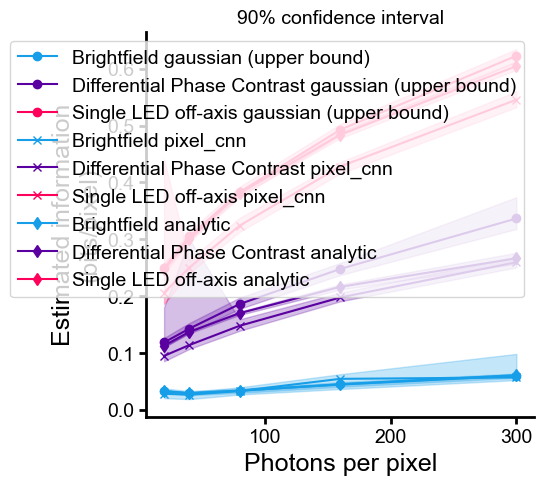

In [3]:
from cleanplots import *

colors =  get_color_cycle()
markers = ['o', 'x', 'd']
models = ['gaussian (upper bound)', 'pixel_cnn', 'analytic']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, (means, confidences) in enumerate(zip([mi_means_by_channel_photons, mi_means_by_channel_photons_pixel_cnn, mi_means_by_channel_photons_analytic], 
                              [mi_confidences_by_channel_photons, mi_confidences_by_channel_photons_pixel_cnn, mi_confidences_by_channel_photons_analytic])):
    for channel, color in zip(channel_names, colors):
        ax.plot(photons_per_pixel, means[channel], label=get_display_channel_names(channel) + ' ' + models[i],
                color=color, linestyle='-', marker=markers[i])
        ax.fill_between(photons_per_pixel, confidences[channel][:, 0], confidences[channel][:, 1], alpha=0.25, color=color)

ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)')
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence_interval}% confidence interval')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/analytic_vs_nll_entropy.pdf', transparent=True)